# Set up libraries

In [3]:
# Core
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
import os

# Display
from IPython.display import display, HTML

# Excel
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns  # Consider adding for better statistical plots

# PowerPoint (if needed - remove if not used)
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
from pptx.enum.text import PP_ALIGN
from openpyxl.chart import *

# ---- Notebook Configuration ----
warnings.filterwarnings("ignore")

# Pandas display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
pd.set_option("display.max_rows", 100)  # Add this for better data viewing
pd.set_option("display.float_format", "{:.2f}".format)  # Clean float display
pd.options.mode.chained_assignment = None

# Matplotlib defaults
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.dpi"] = 300  # Higher quality for Excel export
plt.rcParams["figure.figsize"] = (10, 6)  # Default figure size

# Seaborn style (if using seaborn)
# sns.set_style("whitegrid")
# sns.set_palette("husl")

## Load Data

In [4]:
# ---- Load your data ----
data_path = Path(
    r"C:\Users\james.gilmore\Downloads\1774_INB_OD.Tran.Combo_20260203 (1).csv")


df = pd.read_csv(data_path, encoding="utf-8-sig", low_memory=False)

# Track the source file path for reference
df._source_path = str(data_path)

# Quick sanity check
print(f"Loaded file: {data_path.name}")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
display(df.head())


Loaded file: 1774_INB_OD.Tran.Combo_20260203 (1).csv
Shape: 17,705 rows × 16 columns


,AcctNo,TOTALITEMS,PaidItems,ReturnedItems,ODLimit,ODStatus,ProdCode,BusinessFlag,AccountStatus,RegEValue,OpenDate,AvgColBal,DepositAmount,DepositCount,swipes,spend
0,E76910499717D2787C7F1B5E14931AF04A7F0B31,0,0,NaN,0.00,0,0F,P,O,N,2006-01-31 00:00:00.000,304014,6827.00,0\t0.00\t0.00\t0.00\t0.00,0,0.00
1,01DAE23F510FF2199AC1F07E2865422999A07CFE,0,0,NaN,0.00,0,0X,P,O,D,2006-03-09 00:00:00.000,813390,132655.48,9\t0.00\t0.00\t0.00\t0.00,0,0.00
2,865544AFF67CE1E97C18678A0F60FE8E071234B8,0,0,NaN,0.00,0,0D,B,O,D,2005-08-02 00:00:00.000,777,100.00,1\t0.00\t0.00\t0.00\t0.00,0,0.00
3,912FC622B0CC1EEC569F5758046E794837E4B8B2,0,0,NaN,0.00,0,06,B,O,D,2012-12-26 00:00:00.000,11804,233.20,2\t0.00\t0.00\t0.00\t0.00,0,0.00
4,35ED276657F31BF43FBF4155694C5FFE784C05FE,1,1,NaN,0.00,0,0L,P,O,N,2002-09-04 00:00:00.000,24,0.00,0\t30.00\t0.00\t0.00\t0.00,0,0.00


# Update field headers if necessary
## Field Header | New Name

In [14]:
# ---- Normalize Column Headers ----
print("Current columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")
print(f"\nTotal columns: {len(df.columns)}")

def to_canonical(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize column names to canonical format for consistent analysis."""
    
    def norm(s: str) -> str:
        """Normalize string: lowercase, remove spaces/underscores."""
        return s.strip().lower().replace(" ", "").replace("_", "")
    
    # Mapping of normalized names to canonical names
    # Include both raw names AND already-canonical names
    alias_map = {
        # Activity
        "swipes": "Swipes",
        "transamt": "TransAmt",
        
        # Account ID
        "acctno": "AcctNo",
        
        # Items - handle all variations
        "TOTALITEMS": "Total Items",
        "totalitems": "Total Items",
        "itemspaid": "Paid Items",
        "paiditems": "Paid Items",
        "PaidItems": "Paid Items",
        "returneditems": "Returned Items",
        "ReturnedItems": "Returned Items",
        
        # OD/Limits
        "odlimit": "OD Limit",
        "overdraftlimit": "OD Limit",
        
        # Status codes
        "statcode": "Stat Code",
        "odcode": "Stat Code",
        "prodcode": "Product Code",
        "productcode": "Product Code",
        
        # Flags
        "business?": "Business Flag",
        "businessflag": "Business Flag",
        "regeflag": "Reg E Flag",
        "rege": "Reg E Flag",
        
        # Account status
        "acctstat": "Account Status",
        "accountstatus": "Account Status",
        "opstatus": "Account Status",
        
        # Dates & Balances
        "dateopen": "Open Date",
        "opendate": "Open Date",
        "avgbal": "Avg Collected Balance",
        "avgcolbal": "Avg Collected Balance",
        "averagecollectedbalance": "Avg Collected Balance",
        
        # Deposits
        "#ofdeposits": "Deposit Count",
        "numberofdeposits": "Deposit Count",
        "deps": "Deposit Count",
        "depsamt": "Deposit Amount",
        "deps_amt": "Deposit Amount",
        "depositamount": "Deposit Amount",
    }
    
    # Build rename mapping
    rename_map = {}
    
    for col in df.columns:
        normalized = norm(col)
        if normalized in alias_map:
            rename_map[col] = alias_map[normalized]
        else:
            # Keep original if no mapping found
            rename_map[col] = col
    
    # Apply renaming
    df_renamed = df.rename(columns=rename_map)
    
    # Report what changed
    changed = [(old, new) for old, new in rename_map.items() if old != new]
    if changed:
        print(f"\n✓ Column mappings applied:")
        for old, new in changed:
            print(f"  '{old}' → '{new}'")
    else:
        print("\n✓ All columns already in canonical form")
    
    print(f"\nFinal columns ({len(df_renamed.columns)}):")
    for i, col in enumerate(df_renamed.columns, 1):
        print(f"  {i:2d}. {col}")
    
    return df_renamed

# Apply normalization
df = to_canonical(df)

# Data validation
print("\n" + "="*50)
print("DATA VALIDATION")
print("="*50)

# Check data types
print("\nData types:")
for col, dtype in df.dtypes.items():
    print(f"  {col:25} {dtype}")

# Check for nulls
null_counts = df.isnull().sum()
if null_counts.any():
    print(f"\n⚠️ Columns with null values:")
    for col, count in null_counts[null_counts > 0].items():
        print(f"  {col:25} {count:,} ({count/len(df)*100:.1f}%)")
else:
    print("\n✓ No null values found")

# Basic statistics for key numeric columns
print("\nKey metrics:")
if 'Total Items' in df.columns:
    print(f"  Accounts with items: {(df['Total Items'] > 0).sum():,}")
if 'TransAmt' in df.columns:
    print(f"  Total spend: ${df['TransAmt'].sum():,.2f}")
if 'Account Status' in df.columns:
    print(f"  Active accounts: {(df['Account Status'] == 'Open').sum():,}")

Current columns:
   1. AcctNo
   2. Total Items
   3. Paid Items
   4. Returned Items
   5. OD Limit
   6. ODStatus
   7. Product Code
   8. Business Flag
   9. Account Status
  10. RegEValue
  11. Open Date
  12. Avg Collected Balance
  13. Deposit Amount
  14. DepositCount
  15. Swipes
  16. spend

Total columns: 16

✓ All columns already in canonical form

Final columns (16):
   1. AcctNo
   2. Total Items
   3. Paid Items
   4. Returned Items
   5. OD Limit
   6. ODStatus
   7. Product Code
   8. Business Flag
   9. Account Status
  10. RegEValue
  11. Open Date
  12. Avg Collected Balance
  13. Deposit Amount
  14. DepositCount
  15. Swipes
  16. spend

DATA VALIDATION

Data types:
  AcctNo                    object
  Total Items               int64
  Paid Items                int64
  Returned Items            float64
  OD Limit                  float64
  ODStatus                  int64
  Product Code              object
  Business Flag             object
  Account Status         

# Global formatting

### Powerpoint

In [6]:
# ---- Global Formatting Functions ----

# PowerPoint Configuration
PPT_HEADER_COLOR = RGBColor(204, 229, 255)  # Light blue
PPT_TOTAL_COLOR = RGBColor(240, 240, 240)   # Light gray
PPT_FONT_SIZE = 10
PPT_HEADER_FONT_SIZE = 11

def format_ppt_table(table, data, header_fill=PPT_HEADER_COLOR):
    """
    Apply executive-quality formatting to PowerPoint tables.
    
    Parameters:
    -----------
    table : pptx.table.Table
        The PowerPoint table object to format
    data : pd.DataFrame
        The data being displayed in the table
    header_fill : RGBColor, optional
        Color for header row background
    
    Returns:
    --------
    pptx.table.Table : The formatted table
    """
    rows, cols = data.shape
    
    # Define column width mapping
    col_widths = {
        0: Inches(1.6),  # First column (usually labels) wider
        # Add more specific widths as needed
    }
    default_width = Inches(1.0)
    
    # Apply column widths
    for col_idx in range(cols):
        table.columns[col_idx].width = col_widths.get(col_idx, default_width)
    
    # Format header row
    _format_header_row(table, data, header_fill)
    
    # Format body rows
    _format_body_rows(table, data)
    
    # Set uniform row heights
    for row_idx in range(rows + 1):
        table.rows[row_idx].height = Inches(0.28)
    
    return table


def _format_header_row(table, data, header_fill):
    """Format the header row of the table."""
    for col_idx, col_name in enumerate(data.columns):
        cell = table.cell(0, col_idx)
        cell.text = str(col_name)
        
        # Background color
        cell.fill.solid()
        cell.fill.fore_color.rgb = header_fill
        
        # Text formatting
        p = cell.text_frame.paragraphs[0]
        p.font.bold = True
        p.font.size = Pt(PPT_HEADER_FONT_SIZE)
        p.alignment = PP_ALIGN.CENTER
        
        # Margins
        _set_cell_margins(cell.text_frame)


def _format_body_rows(table, data):
    """Format the body rows of the table."""
    for r_idx, (_, row) in enumerate(data.iterrows(), start=1):
        is_total_row = _is_total_row(row, data.columns[0])
        
        for c_idx, col_name in enumerate(data.columns):
            cell = table.cell(r_idx, c_idx)
            
            # Format value
            cell.text = _format_cell_value(row[col_name], col_name)
            
            # Apply styling
            p = cell.text_frame.paragraphs[0]
            p.font.size = Pt(PPT_FONT_SIZE)
            p.alignment = PP_ALIGN.CENTER
            
            # Special formatting for total rows
            if is_total_row:
                p.font.bold = True
                cell.fill.solid()
                cell.fill.fore_color.rgb = PPT_TOTAL_COLOR
            
            # Set margins
            _set_cell_margins(cell.text_frame)


def _format_cell_value(value, col_name):
    """
    Format a cell value based on its type and column name.
    
    Parameters:
    -----------
    value : Any
        The value to format
    col_name : str
        The column name (used to determine formatting rules)
    
    Returns:
    --------
    str : Formatted string representation
    """
    # Handle missing values
    if pd.isna(value) or value == "":
        return ""
    
    # Handle string values
    if not isinstance(value, (int, float, np.integer, np.floating)):
        return str(value)
    
    # Define column formatting rules
    formatting_rules = {
        # Percentages
        'percentage': {
            'columns': lambda x: "%" in x and "Pay Rate" not in x,
            'format': lambda v: f"{v:.1f}%"
        },
        'pay_rate': {
            'columns': lambda x: x == "% Pay Rate",
            'format': lambda v: f"{v*100:.0f}%" if v <= 1 else f"{v:.0f}%"
        },
        # Counts (integers)
        'counts': {
            'columns': lambda x: any(term in x for term in [
                'Accounts', '# of', 'Items', 'Total OD/NSF'
            ]),
            'format': lambda v: f"{int(v):,}"
        },
        # Currency
        'currency': {
            'columns': lambda x: "$$" in x or x == 'Average of OD Limit',
            'format': lambda v: f"${v:,.0f}" if abs(v) >= 1000 else f"${v:.2f}"
        },
        # Ratios
        'ratio': {
            'columns': lambda x: x == 'Pay Ratio',
            'format': lambda v: f"{v:.2f}"
        },
        # Averages
        'avg_swipes': {
            'columns': lambda x: x == 'Average of Swipes',
            'format': lambda v: f"{int(round(v)):,}"
        },
        'avg_other': {
            'columns': lambda x: "Avg" in x and "$$" not in x,
            'format': lambda v: f"{v:.1f}"
        },
        # Medians
        'median': {
            'columns': lambda x: "Med" in x and "$$" not in x,
            'format': lambda v: f"{v:.1f}"
        }
    }
    
    # Apply formatting rules
    for rule_name, rule in formatting_rules.items():
        if rule['columns'](col_name):
            return rule['format'](value)
    
    # Default formatting for other numbers
    return f"{value:,.0f}" if abs(value) >= 1000 else f"{value:.2f}"


def _is_total_row(row, first_col_name):
    """Check if this is a total/summary row."""
    first_val = str(row[first_col_name]).lower()
    return any(term in first_val for term in ['total', 'summary', 'overall'])


def _set_cell_margins(text_frame, left=0.05, right=0.05, top=0.02, bottom=0.02):
    """Set consistent margins for a cell's text frame."""
    text_frame.margin_left = Inches(left)
    text_frame.margin_right = Inches(right)
    text_frame.margin_top = Inches(top)
    text_frame.margin_bottom = Inches(bottom)



### Jupyter


In [7]:
# ---- Jupyter Notebook Table Styling ----

def style_jupyter_table(df):
    """
    Apply professional styling to DataFrames displayed in Jupyter notebooks.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to style
        
    Returns:
    --------
    pd.io.formats.style.Styler : Styled DataFrame
    """
    
    def make_formatter(col_name):
        """Create appropriate formatter for a column based on its name."""
        
        # Percentage columns
        if '%' in col_name:
            if col_name == '% Pay Rate':
                return lambda x: f"{x:.0%}" if pd.notnull(x) and isinstance(x, (int, float)) else ""
            else:
                return lambda x: f"{x:,.2f}%" if pd.notnull(x) and isinstance(x, (int, float)) else ""
        
        # Count/Integer columns
        count_cols = [
            'Accounts', '# of Accounts', '# of Items', '# of Paid Items',
            'Total OD/NSF Items', '# of Items Paid'
        ]
        if col_name in count_cols:
            return lambda x: f"{int(x):,}" if pd.notnull(x) and isinstance(x, (int, float)) else ""
        
        # Currency columns
        if "$$" in col_name or col_name == 'Average of OD Limit':
            return lambda x: (
                f"${x:,.0f}" if pd.notnull(x) and isinstance(x, (int, float)) and abs(x) >= 1000 
                else f"${x:,.2f}" if pd.notnull(x) and isinstance(x, (int, float)) 
                else ""
            )
        
        # Special average formatting
        if col_name == 'Average of Swipes':
            return lambda x: f"{int(round(x)):,}" if pd.notnull(x) and isinstance(x, (int, float)) else ""
        
        # General averages and medians
        if "Avg" in col_name or "Med" in col_name:
            return lambda x: f"{x:.2f}" if pd.notnull(x) and isinstance(x, (int, float)) else ""
        
        # Default numeric formatting
        return lambda x: (
            f"{x:,.2f}" if pd.notnull(x) and isinstance(x, (int, float)) 
            else str(x) if pd.notnull(x) 
            else ""
        )
    
    # Build format dictionary
    format_dict = {col: make_formatter(col) for col in df.columns}
    
    # Apply styling
    styled = (
        df.style
        .format(format_dict, na_rep="")
        .set_table_styles([
            {
                'selector': 'thead th',
                'props': [
                    ('background-color', '#cce5ff'),
                    ('color', '#000'),
                    ('font-weight', 'bold'),
                    ('font-size', '12pt'),
                    ('text-align', 'center'),
                    ('padding', '8px'),
                    ('border', '1px solid #ddd')
                ]
            },
            {
                'selector': 'tbody tr:last-child',
                'props': [
                    ('font-weight', 'bold'),
                    ('background-color', '#f0f0f0'),
                    ('border-top', '2px solid #666')
                ]
            },
            {
                'selector': 'tbody td',
                'props': [
                    ('padding', '6px'),
                    ('border', '1px solid #ddd')
                ]
            },
            {
                'selector': 'tbody tr:hover',
                'props': [
                    ('background-color', '#f5f5f5')
                ]
            }
        ])
        .set_properties(**{
            'text-align': 'center',
            'font-size': '11pt',
            'font-family': 'Arial, sans-serif'
        })
        .hide(axis="index")
    )
    
    # Highlight negative values in red
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    styled = styled.applymap(
        lambda x: 'color: red' if isinstance(x, (int, float)) and x < 0 else '',
        subset=numeric_cols
    )
    
    return styled

In [8]:
# ---- Test Jupyter Table Styling ----

# Create test data with various column types
test_data = {
    'Account Type': ['Personal', 'Business', 'Premium', 'Student', 'Grand Total'],
    'Accounts': [1500, 800, 350, 250, 2900],
    '# of Items': [4500, 2300, 1050, 450, 8300],
    '# of Paid Items': [3600, 1840, 850, 360, 6650],
    'Total OD/NSF Items': [900, 460, 200, 90, 1650],
    '% Pay Rate': [0.80, 0.80, 0.81, 0.80, 0.8024],
    'OD %': [25.5, 30.2, 22.8, 18.4, 24.9],
    'Average of Swipes': [125.7, 89.3, 156.8, 45.2, 104.25],
    'Average of OD Limit': [500.00, 750.50, 1200.00, 250.00, 675.125],
    '$$ Revenue': [125000.50, 85000.00, 95000.75, 15000.25, 320001.50],
    '$$ Small Amt': [50.25, 75.50, 125.75, 25.00, 276.50],
    'Avg Days': [45.2, 52.8, 38.5, 60.1, 49.15],
    'Med Balance': [1250.50, 2100.00, 3500.75, 450.25, 1825.375],
    'Pay Ratio': [1.25, 1.18, 1.35, 0.95, 1.1825],
    'Negative Value': [100, -50, 200, -25, 225]
}

test_df = pd.DataFrame(test_data)

print("Test DataFrame Preview:")
print(test_df.to_string())
print("\n" + "="*50 + "\n")

# Apply styling and display
print("Styled Table (see output below):")
styled_table = style_jupyter_table(test_df)
display(styled_table)

# Test edge cases
print("\n" + "="*50 + "\n")
print("Testing edge cases...")

# Test with NaN values
test_df_with_nan = test_df.copy()
test_df_with_nan.loc[1, '$$ Revenue'] = np.nan
test_df_with_nan.loc[2, '% Pay Rate'] = np.nan
test_df_with_nan.loc[0, 'Average of Swipes'] = np.nan

print("Table with NaN values:")
display(style_jupyter_table(test_df_with_nan))

# Test with very large and very small numbers
test_extreme = pd.DataFrame({
    'Description': ['Large Currency', 'Small Currency', 'Large Count', 'Tiny Percentage'],
    '$$ Amount': [1500000, 5.50, 999.99, 0.001],
    '# of Items': [1000000, 5, 999999, 1],
    'Rate %': [95.5, 0.05, 50.0, 0.0001]
})

print("\n" + "="*50 + "\n")
print("Table with extreme values:")
display(style_jupyter_table(test_extreme))

Test DataFrame Preview:
  Account Type  Accounts  # of Items  # of Paid Items  Total OD/NSF Items  % Pay Rate  OD %  Average of Swipes  Average of OD Limit  $$ Revenue  $$ Small Amt  Avg Days  Med Balance  Pay Ratio  Negative Value
0     Personal      1500        4500             3600                 900        0.80 25.50             125.70               500.00   125000.50         50.25     45.20      1250.50       1.25             100
1     Business       800        2300             1840                 460        0.80 30.20              89.30               750.50    85000.00         75.50     52.80      2100.00       1.18             -50
2      Premium       350        1050              850                 200        0.81 22.80             156.80              1200.00    95000.75        125.75     38.50      3500.75       1.35             200
3      Student       250         450              360                  90        0.80 18.40              45.20               250.00    15000.25 

Account Type,Accounts,# of Items,# of Paid Items,Total OD/NSF Items,% Pay Rate,OD %,Average of Swipes,Average of OD Limit,$$ Revenue,$$ Small Amt,Avg Days,Med Balance,Pay Ratio,Negative Value
Personal,"1,500","4,500","3,600",900,80%,25.50%,126,$500.00,"$125,000",$50.25,45.20,1250.50,1.25,100.00
Business,800,"2,300","1,840",460,80%,30.20%,89,$750.50,"$85,000",$75.50,52.80,2100.00,1.18,-50.00
Premium,350,"1,050",850,200,81%,22.80%,157,"$1,200","$95,001",$125.75,38.50,3500.75,1.35,200.00
Student,250,450,360,90,80%,18.40%,45,$250.00,"$15,000",$25.00,60.10,450.25,0.95,-25.00
Grand Total,"2,900","8,300","6,650","1,650",80%,24.90%,104,$675.12,"$320,002",$276.50,49.15,1825.38,1.18,225.00




Testing edge cases...
Table with NaN values:


Account Type,Accounts,# of Items,# of Paid Items,Total OD/NSF Items,% Pay Rate,OD %,Average of Swipes,Average of OD Limit,$$ Revenue,$$ Small Amt,Avg Days,Med Balance,Pay Ratio,Negative Value
Personal,"1,500","4,500","3,600",900,80%,25.50%,,$500.00,"$125,000",$50.25,45.20,1250.50,1.25,100.00
Business,800,"2,300","1,840",460,80%,30.20%,89,$750.50,,$75.50,52.80,2100.00,1.18,-50.00
Premium,350,"1,050",850,200,,22.80%,157,"$1,200","$95,001",$125.75,38.50,3500.75,1.35,200.00
Student,250,450,360,90,80%,18.40%,45,$250.00,"$15,000",$25.00,60.10,450.25,0.95,-25.00
Grand Total,"2,900","8,300","6,650","1,650",80%,24.90%,104,$675.12,"$320,002",$276.50,49.15,1825.38,1.18,225.00




Table with extreme values:


Description,$$ Amount,# of Items,Rate %
Large Currency,"$1,500,000","1,000,000",95.50%
Small Currency,$5.50,5,0.05%
Large Count,$999.99,"999,999",50.00%
Tiny Percentage,$0.00,1,0.00%


## Excel formatting

In [9]:
# ---- Excel Table Formatting ----

def format_excel_table(excel_path, sheet_name, df):
    """
    Format an Excel sheet containing DataFrame data with professional styling.
    
    Features:
    - Frozen header with autofilter
    - Styled header (blue background, bold)
    - Grand Total row highlighting
    - Zebra striping for readability
    - Smart column widths
    - Appropriate number formatting
    
    Parameters:
    -----------
    excel_path : str or Path
        Path to the Excel file
    sheet_name : str
        Name of the sheet to format
    df : pd.DataFrame
        The data that was written to the sheet
    """
    from openpyxl.styles import Border, Side
    
    # Load workbook
    book = load_workbook(excel_path)
    if sheet_name not in book.sheetnames:
        raise KeyError(f"Sheet '{sheet_name}' not found in {excel_path}")
    sheet = book[sheet_name]
    
    # Define styles
    styles = _define_excel_styles()
    
    # Get dimensions
    n_rows, n_cols = df.shape
    if n_rows == 0 or n_cols == 0:
        book.save(excel_path)
        return
    
    # Format header row
    _format_header_row(sheet, df.columns, styles)
    
    # Format data rows
    _format_data_rows(sheet, df, styles)
    
    # Apply sheet-level formatting
    _apply_sheet_formatting(sheet, n_rows, n_cols)
    
    # Save workbook
    book.save(excel_path)
    book.close()


def _define_excel_styles():
    """Define all Excel styles in one place."""
    thin = Side(style="thin", color="D9D9D9")
    
    return {
        'header_fill': PatternFill(start_color="CCE5FF", end_color="CCE5FF", fill_type="solid"),
        'total_fill': PatternFill(start_color="F0F0F0", end_color="F0F0F0", fill_type="solid"),
        'zebra_fill': PatternFill(start_color="FAFAFA", end_color="FAFAFA", fill_type="solid"),
        'header_font': Font(bold=True, size=11),
        'data_font': Font(size=10),
        'total_font': Font(bold=True, size=10),
        'center_align': Alignment(horizontal="center", vertical="center", wrap_text=False),
        'left_align': Alignment(horizontal="left", vertical="center", wrap_text=False),
        'right_align': Alignment(horizontal="right", vertical="center", wrap_text=False),
        'border': Border(left=thin, right=thin, top=thin, bottom=thin)
    }


def _format_header_row(sheet, columns, styles):
    """Format the header row."""
    for c, col_name in enumerate(columns, 1):
        cell = sheet.cell(row=1, column=c)
        cell.value = col_name
        cell.fill = styles['header_fill']
        cell.font = styles['header_font']
        cell.alignment = styles['center_align']
        cell.border = styles['border']


def _format_data_rows(sheet, df, styles):
    """Format all data rows with appropriate styles and number formats."""
    n_rows, n_cols = df.shape
    
    for r in range(n_rows):
        excel_row = r + 2
        
        # Check if this is a total row
        is_total_row = _is_total_row(df.iloc[r], df.columns[0])
        
        # Determine row fill (zebra striping or total row)
        if is_total_row:
            row_fill = styles['total_fill']
        elif r % 2 == 1:
            row_fill = styles['zebra_fill']
        else:
            row_fill = None
        
        # Format each cell in the row
        for c in range(n_cols):
            _format_cell(
                sheet.cell(row=excel_row, column=c + 1),
                df.iloc[r, c],
                df.columns[c],
                c == 0,  # is_first_column
                is_total_row,
                row_fill,
                styles
            )


def _format_cell(cell, value, col_name, is_first_column, is_total_row, row_fill, styles):
    """Format an individual cell based on its value and column type."""
    
    # Apply fill and border
    if row_fill:
        cell.fill = row_fill
    cell.border = styles['border']
    
    # Set font
    cell.font = styles['total_font'] if is_total_row else styles['data_font']
    
    # Handle null values
    if pd.isna(value):
        cell.value = None
        cell.alignment = styles['center_align']
        return
    
    # Set alignment based on column position and data type
    if is_first_column:
        cell.alignment = styles['left_align']
    elif isinstance(value, (int, float)):
        cell.alignment = styles['right_align']
    else:
        cell.alignment = styles['center_align']
    
    # Apply number formatting
    if isinstance(value, (int, float)):
        _apply_number_format(cell, value, col_name)
    else:
        cell.value = str(value)


def _apply_number_format(cell, value, col_name):
    """Apply appropriate number format based on column name."""
    
    # Define column categories
    count_columns = {
        'Accounts', '# of Accounts', '# of Items', '# of Paid Items',
        'Total OD/NSF Items', '# of Items Paid'
    }
    
    # Percentage columns (excluding % Pay Rate)
    if '%' in col_name and col_name != '% Pay Rate':
        cell.value = float(value) / 100.0  # Convert to Excel percentage
        cell.number_format = '0.0%'
    
    # % Pay Rate (already 0-1)
    elif col_name == '% Pay Rate':
        cell.value = float(value)
        cell.number_format = '0%'
    
    # Count columns
    elif col_name in count_columns:
        cell.value = int(round(value))
        cell.number_format = '#,##0'
    
    # Currency columns
    elif '$$' in col_name or col_name == 'Average of OD Limit':
        cell.value = float(value)
        cell.number_format = '$#,##0' if abs(value) >= 1000 else '$#,##0.00'
    
    # Special cases
    elif col_name == 'Average of Swipes':
        cell.value = int(round(value))
        cell.number_format = '#,##0'
    
    elif col_name == 'Pay Ratio':
        cell.value = float(value)
        cell.number_format = '0.00'
    
    # Averages and medians
    elif any(term in col_name.lower() for term in ['avg', 'med']):
        cell.value = float(value)
        cell.number_format = '#,##0.00'
    
    # Default numeric format
    else:
        cell.value = float(value)
        cell.number_format = '#,##0.00' if abs(value) >= 1000 else '0.00'


def _is_total_row(row_data, first_col_name):
    """Check if this row is a total/summary row."""
    first_val = str(row_data[first_col_name]).lower()
    return any(term in first_val for term in ['total', 'grand total', 'summary'])


def _apply_sheet_formatting(sheet, n_rows, n_cols):
    """Apply sheet-level formatting like freeze panes and column widths."""
    
    # Freeze header row
    sheet.freeze_panes = "A2"
    
    # Apply autofilter
    sheet.auto_filter.ref = f"A1:{sheet.cell(row=n_rows+1, column=n_cols).coordinate}"
    
    # Set smart column widths
    min_width, max_width = 10, 50
    
    for col_idx in range(1, n_cols + 1):
        column_letter = sheet.cell(row=1, column=col_idx).column_letter
        
        # Calculate max length in column
        max_length = len(str(sheet.cell(row=1, column=col_idx).value or ""))
        
        for row_idx in range(2, n_rows + 2):
            cell_value = sheet.cell(row=row_idx, column=col_idx).value
            if cell_value:
                # Account for number formatting (commas, $, %)
                display_length = len(str(cell_value))
                if isinstance(cell_value, (int, float)):
                    display_length += 3  # Buffer for formatting
                max_length = max(max_length, display_length)
        
        # Set width with constraints
        optimal_width = max_length + 2
        sheet.column_dimensions[column_letter].width = max(min_width, min(max_width, optimal_width))

In [10]:
# ---- Excel Table Formatting ----

def format_excel_table(excel_path, sheet_name, df):
    """
    Format an Excel sheet containing DataFrame data with professional styling.
    
    Features:
    - Frozen header with autofilter
    - Styled header (blue background, bold)
    - Grand Total row highlighting
    - Zebra striping for readability
    - Smart column widths
    - Appropriate number formatting
    
    Parameters:
    -----------
    excel_path : str or Path
        Path to the Excel file
    sheet_name : str
        Name of the sheet to format
    df : pd.DataFrame
        The data that was written to the sheet
    """
    from openpyxl.styles import Border, Side
    
    # Load workbook
    book = load_workbook(excel_path)
    if sheet_name not in book.sheetnames:
        raise KeyError(f"Sheet '{sheet_name}' not found in {excel_path}")
    sheet = book[sheet_name]
    
    # Define styles
    styles = _define_excel_styles()
    
    # Get dimensions
    n_rows, n_cols = df.shape
    if n_rows == 0 or n_cols == 0:
        book.save(excel_path)
        return
    
    # Format header row
    _format_header_row(sheet, df.columns, styles)
    
    # Format data rows
    _format_data_rows(sheet, df, styles)
    
    # Apply sheet-level formatting
    _apply_sheet_formatting(sheet, n_rows, n_cols)
    
    # Save workbook
    book.save(excel_path)
    book.close()


def _define_excel_styles():
    """Define all Excel styles in one place."""
    from openpyxl.styles import Border, Side
    
    thin = Side(style="thin", color="D9D9D9")
    
    return {
        'header_fill': PatternFill(start_color="CCE5FF", end_color="CCE5FF", fill_type="solid"),
        'total_fill': PatternFill(start_color="F0F0F0", end_color="F0F0F0", fill_type="solid"),
        'zebra_fill': PatternFill(start_color="FAFAFA", end_color="FAFAFA", fill_type="solid"),
        'header_font': Font(bold=True, size=11),
        'data_font': Font(size=10),
        'total_font': Font(bold=True, size=10),
        'center_align': Alignment(horizontal="center", vertical="center", wrap_text=False),
        'left_align': Alignment(horizontal="left", vertical="center", wrap_text=False),
        'right_align': Alignment(horizontal="right", vertical="center", wrap_text=False),
        'border': Border(left=thin, right=thin, top=thin, bottom=thin)
    }


def _format_header_row(sheet, columns, styles):
    """Format the header row."""
    for c, col_name in enumerate(columns, 1):
        cell = sheet.cell(row=1, column=c)
        cell.value = col_name
        cell.fill = styles['header_fill']
        cell.font = styles['header_font']
        cell.alignment = styles['center_align']
        cell.border = styles['border']


def _format_data_rows(sheet, df, styles):
    """Format all data rows with appropriate styles and number formats."""
    n_rows, n_cols = df.shape
    
    for r in range(n_rows):
        excel_row = r + 2
        
        # Check if this is a total row
        is_total_row = _is_total_row(df.iloc[r], df.columns[0])
        
        # Determine row fill (zebra striping or total row)
        if is_total_row:
            row_fill = styles['total_fill']
        elif r % 2 == 1:
            row_fill = styles['zebra_fill']
        else:
            row_fill = None
        
        # Format each cell in the row
        for c in range(n_cols):
            _format_cell(
                sheet.cell(row=excel_row, column=c + 1),
                df.iloc[r, c],
                df.columns[c],
                c == 0,  # is_first_column
                is_total_row,
                row_fill,
                styles
            )


def _format_cell(cell, value, col_name, is_first_column, is_total_row, row_fill, styles):
    """Format an individual cell based on its value and column type."""
    
    # Apply fill and border
    if row_fill:
        cell.fill = row_fill
    cell.border = styles['border']
    
    # Set font
    cell.font = styles['total_font'] if is_total_row else styles['data_font']
    
    # Handle null values
    if pd.isna(value):
        cell.value = None
        cell.alignment = styles['center_align']
        return
    
    # Set alignment based on column position and data type
    if is_first_column:
        cell.alignment = styles['left_align']
    elif isinstance(value, (int, float)):
        cell.alignment = styles['right_align']
    else:
        cell.alignment = styles['center_align']
    
    # Apply number formatting
    if isinstance(value, (int, float)):
        _apply_number_format(cell, value, col_name)
    else:
        cell.value = str(value)


def _apply_number_format(cell, value, col_name):
    """Apply appropriate number format based on column name."""
    
    # Define column categories
    count_columns = {
        'Accounts', '# of Accounts', '# of Items', '# of Paid Items',
        'Total OD/NSF Items', '# of Items Paid'
    }
    
    # Percentage columns (excluding % Pay Rate)
    if '%' in col_name and col_name != '% Pay Rate':
        cell.value = float(value) / 100.0  # Convert to Excel percentage
        cell.number_format = '0.0%'
    
    # % Pay Rate (already 0-1)
    elif col_name == '% Pay Rate':
        cell.value = float(value)
        cell.number_format = '0%'
    
    # Count columns
    elif col_name in count_columns:
        cell.value = int(round(value))
        cell.number_format = '#,##0'
    
    # Currency columns
    elif '$$' in col_name or col_name == 'Average of OD Limit':
        cell.value = float(value)
        cell.number_format = '$#,##0' if abs(value) >= 1000 else '$#,##0.00'
    
    # Special cases
    elif col_name == 'Average of Swipes':
        cell.value = int(round(value))
        cell.number_format = '#,##0'
    
    elif col_name == 'Pay Ratio':
        cell.value = float(value)
        cell.number_format = '0.00'
    
    # Averages and medians
    elif any(term in col_name.lower() for term in ['avg', 'med']):
        cell.value = float(value)
        cell.number_format = '#,##0.00'
    
    # Default numeric format
    else:
        cell.value = float(value)
        cell.number_format = '#,##0.00' if abs(value) >= 1000 else '0.00'


def _is_total_row(row_data, first_col_name):
    """Check if this row is a total/summary row."""
    first_val = str(row_data[first_col_name]).lower()
    return any(term in first_val for term in ['total', 'grand total', 'summary'])


def _apply_sheet_formatting(sheet, n_rows, n_cols):
    """Apply sheet-level formatting like freeze panes and column widths."""
    
    # Freeze header row
    sheet.freeze_panes = "A2"
    
    # Apply autofilter
    sheet.auto_filter.ref = f"A1:{sheet.cell(row=n_rows+1, column=n_cols).coordinate}"
    
    # Set smart column widths
    min_width, max_width = 10, 50
    
    for col_idx in range(1, n_cols + 1):
        column_letter = sheet.cell(row=1, column=col_idx).column_letter
        
        # Calculate max length in column
        max_length = len(str(sheet.cell(row=1, column=col_idx).value or ""))
        
        for row_idx in range(2, n_rows + 2):
            cell_value = sheet.cell(row=row_idx, column=col_idx).value
            if cell_value:
                # Account for number formatting (commas, $, %)
                display_length = len(str(cell_value))
                if isinstance(cell_value, (int, float)):
                    display_length += 3  # Buffer for formatting
                max_length = max(max_length, display_length)
        
        # Set width with constraints
        optimal_width = max_length + 2
        sheet.column_dimensions[column_letter].width = max(min_width, min(max_width, optimal_width))

# Sample Powerpoint usage

In [11]:
# ---- PowerPoint Table Usage Reference ----

"""
Quick reference for adding formatted tables to PowerPoint presentations.

Basic usage:
------------
# Create or load presentation
prs = Presentation()  # New presentation
# OR: prs = Presentation('existing.pptx')  # Existing presentation

# Add slide (layout 5 = Title Only)
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Your Title Here"

# Calculate table dimensions
rows = len(df) + 1  # +1 for header
cols = len(df.columns)

# Add table to slide
# Parameters: (rows, cols, left, top, width, height)
table_shape = slide.shapes.add_table(
    rows, cols,
    Inches(0.5),   # left margin
    Inches(1.5),   # top margin (below title)
    Inches(9.0),   # width (adjust for your slide)
    Inches(0.3 * rows + 0.5)  # dynamic height based on rows
)

# Apply formatting
format_ppt_table(table_shape.table, df)

# Save presentation
prs.save("output.pptx")

Layout options:
--------------
0 - Title Slide
1 - Title and Content
5 - Title Only (recommended for tables)
6 - Blank

Table positioning tips:
----------------------
- Standard slide: 10" × 7.5"
- Safe margins: 0.5" on all sides
- Title area: ~1.2" from top
- Max table width: ~9"
- Row height: ~0.28-0.35" per row
"""

'\nQuick reference for adding formatted tables to PowerPoint presentations.\n\nBasic usage:\n------------\n# Create or load presentation\nprs = Presentation()  # New presentation\n# OR: prs = Presentation(\'existing.pptx\')  # Existing presentation\n\n# Add slide (layout 5 = Title Only)\nslide = prs.slides.add_slide(prs.slide_layouts[5])\nslide.shapes.title.text = "Your Title Here"\n\n# Calculate table dimensions\nrows = len(df) + 1  # +1 for header\ncols = len(df.columns)\n\n# Add table to slide\n# Parameters: (rows, cols, left, top, width, height)\ntable_shape = slide.shapes.add_table(\n    rows, cols,\n    Inches(0.5),   # left margin\n    Inches(1.5),   # top margin (below title)\n    Inches(9.0),   # width (adjust for your slide)\n    Inches(0.3 * rows + 0.5)  # dynamic height based on rows\n)\n\n# Apply formatting\nformat_ppt_table(table_shape.table, df)\n\n# Save presentation\nprs.save("output.pptx")\n\nLayout options:\n--------------\n0 - Title Slide\n1 - Title and Content\n5 -

# Create excel report

In [12]:
# ---- Master Excel Report Setup ----

import calendar
from datetime import datetime

# Extract info from the source file name to build report name
source_file_name = df.attrs.get('source_path', '')
if not source_file_name:
    # Fallback to the path if attrs not set
    source_file_name = str(data_path.name) if 'data_path' in locals() else "1616_One Time Data_20250714"

# Extract the ID number (first 4 digits)
import re
match = re.search(r'^(\d{4})', Path(source_file_name).name)
report_id = match.group(1) if match else "0000"

# Get current month and year for report name
now = datetime.now()
month_abbr = calendar.month_abbr[now.month].upper()
year_short = str(now.year)[-2:]

# Build report filename
report_filename = f"{report_id} - ILS Kickoff Report Data-{month_abbr}{year_short}.xlsx"
report_path = Path(report_filename)

print(f"Creating Master Excel Report: {report_filename}")
print(f"Based on source file: {Path(source_file_name).name}")

# Create new workbook
wb = Workbook()

# Remove default sheet and create cover sheet
if 'Sheet' in wb.sheetnames:
    wb.remove(wb['Sheet'])

# Create cover sheet with report info
cover_sheet = wb.create_sheet("Report Info")
cover_sheet['A1'] = "ILS Kickoff Report"
cover_sheet['A1'].font = Font(size=20, bold=True)

cover_sheet['A3'] = "Report Details:"
cover_sheet['A3'].font = Font(size=14, bold=True)

# Report metadata
report_info = [
    ("Client ID:", report_id),
    ("Report Date:", now.strftime("%B %d, %Y")),
    ("Source File:", Path(source_file_name).name),
    ("Total Accounts:", f"{len(df):,}"),
    ("Report Period:", f"{month_abbr} {now.year}"),
    ("Generated By:", "OD Analysis System v1.0")
]

for i, (label, value) in enumerate(report_info, start=4):
    cover_sheet[f'A{i}'] = label
    cover_sheet[f'A{i}'].font = Font(bold=True)
    cover_sheet[f'B{i}'] = value

# Adjust column widths
cover_sheet.column_dimensions['A'].width = 20
cover_sheet.column_dimensions['B'].width = 40

# Save initial workbook
wb.save(report_path)
wb.close()

print(f"✓ Master report created: {report_path}")

# Update the excel_path variable for subsequent analyses
excel_path = report_path

# Helper function to add analysis tabs
def add_analysis_to_report(report_path, sheet_name, data_df, charts=None, insights=None):
    """
    Add an analysis section to the master report.
    
    Parameters:
    -----------
    report_path : Path
        Path to the master Excel report
    sheet_name : str
        Name for the new sheet
    data_df : pd.DataFrame
        The analysis data to add
    charts : list of str, optional
        List of chart image filenames to add
    insights : list of str, optional
        List of insight text to add
    """
    wb = load_workbook(report_path)
    
    # Create new sheet
    if sheet_name in wb.sheetnames:
        wb.remove(wb[sheet_name])
    ws = wb.create_sheet(sheet_name)
    
    # Add title
    ws['A1'] = sheet_name
    ws['A1'].font = Font(size=16, bold=True)
    
    # Write data starting from row 3
    start_row = 3
    for r_idx, row in enumerate(dataframe_to_rows(data_df, index=False, header=True)):
        for c_idx, value in enumerate(row, 1):
            ws.cell(row=start_row + r_idx, column=c_idx, value=value)
    
    # Save to apply data before formatting
    wb.save(report_path)
    wb.close()
    
    # Apply formatting
    format_excel_table(report_path, sheet_name, data_df)
    
    # Add charts if provided
    if charts:
        wb = load_workbook(report_path)
        ws = wb[sheet_name]
        
        table_end_row = start_row + len(data_df) + 3
        
        for i, (chart_file, chart_title) in enumerate(charts):
            if os.path.exists(chart_file):
                img = XLImage(chart_file)
                img.width = 600
                img.height = 360
                
                # Position charts in a grid
                col = 'A' if i % 2 == 0 else 'J'
                row = table_end_row + (i // 2) * 25
                
                # Add chart title
                ws[f'{col}{row - 1}'] = chart_title
                ws[f'{col}{row - 1}'].font = Font(size=12, bold=True)
                
                # Add image
                ws.add_image(img, f'{col}{row}')
        
        wb.save(report_path)
        wb.close()
    
    print(f"✓ Added '{sheet_name}' to report")

Creating Master Excel Report: 1774 - ILS Kickoff Report Data-FEB26.xlsx
Based on source file: 1774_INB_OD.Tran.Combo_20260203 (1).csv
✓ Master report created: 1774 - ILS Kickoff Report Data-FEB26.xlsx


# Slide 1
## Stat Code Analysis - All Accounts

In [16]:
# ---- Analysis 1: Account Status Summary ----

# Verify columns first
print("Using these columns:")
print(f"  Status column: Account Status")
print(f"  Items column: items")
print(f"  Paid column: paid")
print()

# ---- Step 1: Build account summary table ----
stat_code_summary = df.groupby("Account Status").agg(
    **{
        '# of Accounts': ('AcctNo', 'count'),
        '# of Items': ('Total Items', 'sum'),        
        '# of Items Paid': ('Paid Items', 'sum')
    }
).reset_index()

# ---- Step 2: Add percentage columns and Pay Ratio ----
stat_code_summary['% of Accounts'] = (
    stat_code_summary['# of Accounts'] / stat_code_summary['# of Accounts'].sum() * 100
).round(2)

stat_code_summary['% of Items'] = (
    stat_code_summary['# of Items'] / stat_code_summary['# of Items'].sum() * 100
).round(2)

# Handle division by zero for Pay Ratio
stat_code_summary['Pay Ratio'] = np.where(
    stat_code_summary['# of Items'] > 0,
    (stat_code_summary['# of Items Paid'] / stat_code_summary['# of Items']).round(2),
    0
)

# ---- Step 3: Add Grand Total row ----
total_items = stat_code_summary['# of Items'].sum()
total_paid = stat_code_summary['# of Items Paid'].sum()

grand_total = pd.DataFrame([{
    'Account Status': 'Grand Total',
    '# of Accounts': stat_code_summary['# of Accounts'].sum(),
    '# of Items': total_items,
    '# of Items Paid': total_paid,
    '% of Accounts': 100.0,
    '% of Items': 100.0,
    'Pay Ratio': round(total_paid / total_items, 2) if total_items > 0 else 0
}])

# Combine with main summary
stat_code_summary = pd.concat([stat_code_summary, grand_total], ignore_index=True)

# ---- Step 4: Reorder columns for better presentation ----
column_order = [
    'Account Status', 
    '# of Accounts', 
    '% of Accounts',
    '# of Items',
    '% of Items',
    '# of Items Paid',
    'Pay Ratio'
]
stat_code_summary = stat_code_summary[column_order]

# ---- Step 5: Display formatted result ----
print("\nAccount Status Summary:")
display(style_jupyter_table(stat_code_summary))

# Store for later use
analysis_1_data = stat_code_summary.copy()


Using these columns:
  Status column: Account Status
  Items column: items
  Paid column: paid


Account Status Summary:


Account Status,# of Accounts,% of Accounts,# of Items,% of Items,# of Items Paid,Pay Ratio
C,94,0.53%,37,0.11%,37,1.00
D,124,0.70%,0,0.00%,0,0.00
O,"16,613",93.83%,"23,058",68.09%,"23,058",1.00
X,874,4.94%,"10,769",31.80%,"10,769",1.00
Grand Total,"17,705",100.00%,"33,864",100.00%,"33,864",1.00


## Visualization: Accounts vs Pay Ratio by Acct Stat


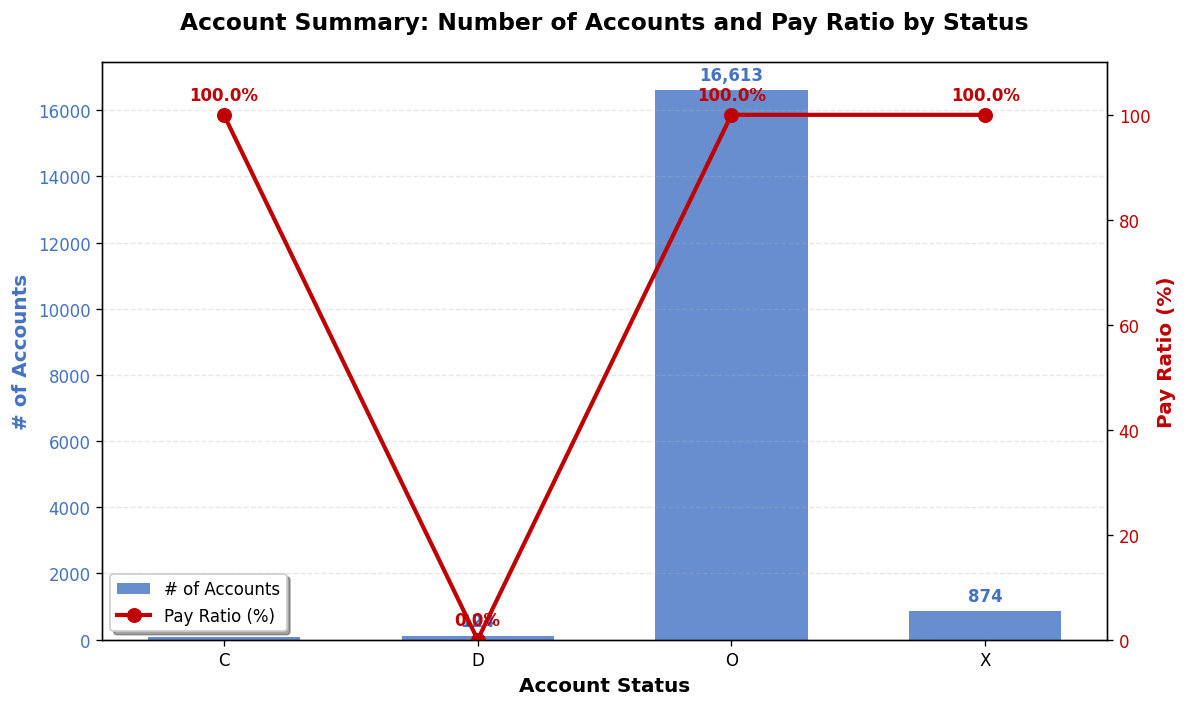

In [17]:
# ---- Visualization: Accounts vs Pay Ratio by Account Status ----

# Filter out Grand Total row
plot_df = stat_code_summary[stat_code_summary['Account Status'] != 'Grand Total'].copy()

# Create figure with specific size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis: Bar chart for # of Accounts
bars = ax1.bar(
    plot_df['Account Status'],
    plot_df['# of Accounts'],
    color='#4472C4',  # Professional blue
    width=0.6,
    label='# of Accounts',
    alpha=0.8
)

# Primary axis formatting
ax1.set_xlabel("Account Status", fontsize=12, fontweight='bold')
ax1.set_ylabel("# of Accounts", color='#4472C4', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#4472C4')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:  # Only label non-zero bars
        ax1.text(
            bar.get_x() + bar.get_width()/2, 
            height + max(plot_df['# of Accounts']) * 0.01,  # Small offset
            f"{int(height):,}", 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            fontweight='bold',
            color='#4472C4'
        )

# Secondary axis: Line chart for Pay Ratio
ax2 = ax1.twinx()
line = ax2.plot(
    plot_df['Account Status'],
    plot_df['Pay Ratio'] * 100,  # Convert to percentage
    color='#C00000',  # Professional red
    marker='o',
    markersize=8,
    linewidth=2.5,
    label='Pay Ratio (%)'
)

# Secondary axis formatting
ax2.set_ylabel("Pay Ratio (%)", color='#C00000', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#C00000')
ax2.set_ylim(0, 110)  # Give some headroom for labels

# Add value labels on line points
for i, (status, ratio) in enumerate(zip(plot_df['Account Status'], plot_df['Pay Ratio'] * 100)):
    ax2.text(
        i, 
        ratio + 2,  # Offset above point
        f"{ratio:.1f}%", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        fontweight='bold',
        color='#C00000'
    )

# Title and formatting
plt.title(
    "Account Summary: Number of Accounts and Pay Ratio by Status", 
    fontsize=14, 
    fontweight='bold', 
    pad=20
)

# Rotate x-axis labels if needed
if len(plot_df) > 4:
    ax1.set_xticklabels(plot_df['Account Status'], rotation=45, ha='right')

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, 
    labels1 + labels2, 
    loc='lower left',
    frameon=True,
    fancybox=True,
    shadow=True
)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Save for Excel export
fig.savefig('account_status_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

## Item Disposition by Account Status

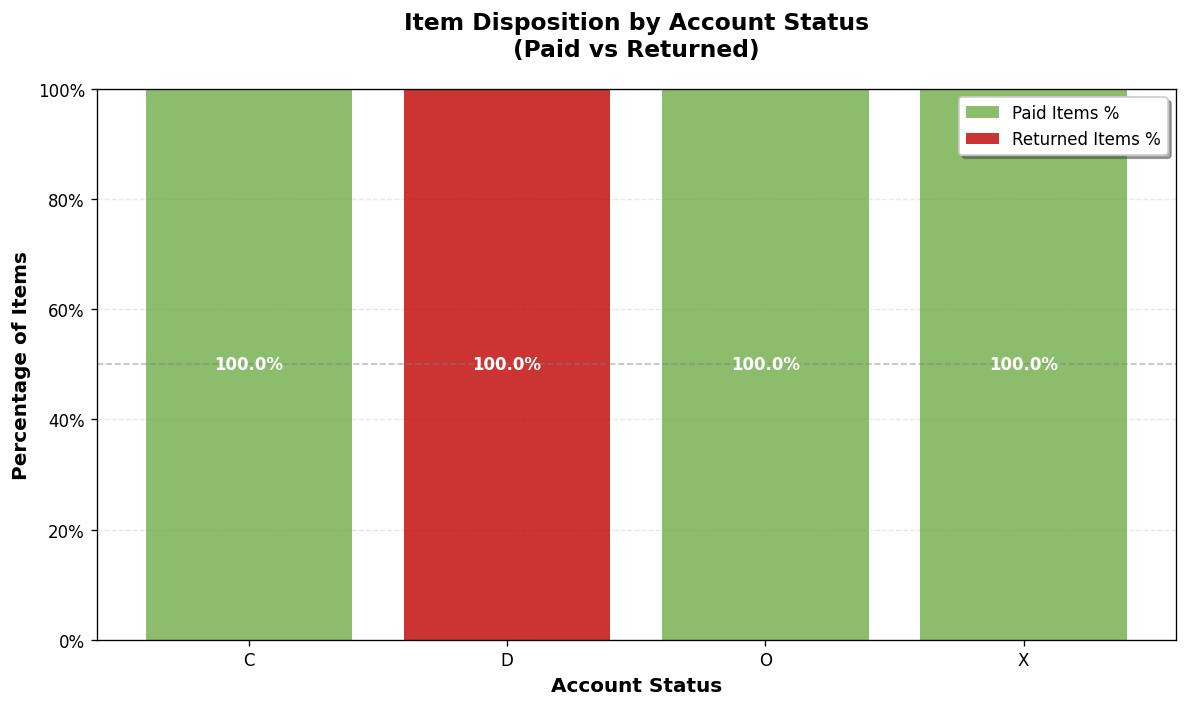


Item Disposition Summary:
C: 100.0% Paid, 0.0% Returned
D: 0.0% Paid, 100.0% Returned
O: 100.0% Paid, 0.0% Returned
X: 100.0% Paid, 0.0% Returned


In [18]:
# ---- Visualization 2: Item Disposition (Paid vs Returned) by Account Status ----

# Prepare data
chart_data = stat_code_summary[stat_code_summary['Account Status'] != 'Grand Total'].copy()

# Calculate returned items and percentages with safe division
chart_data['Returned Items'] = chart_data['# of Items'] - chart_data['# of Items Paid']

# Handle division by zero
chart_data['% Paid'] = np.where(
    chart_data['# of Items'] > 0,
    (chart_data['# of Items Paid'] / chart_data['# of Items'] * 100).round(1),
    0
)
chart_data['% Returned'] = 100 - chart_data['% Paid']

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors
paid_color = '#70AD47'  # Green for paid
returned_color = '#C00000'  # Red for returned

# Create stacked bars
bars1 = ax.bar(
    chart_data['Account Status'], 
    chart_data['% Paid'], 
    label='Paid Items %',
    color=paid_color,
    alpha=0.8
)

bars2 = ax.bar(
    chart_data['Account Status'], 
    chart_data['% Returned'], 
    bottom=chart_data['% Paid'], 
    label='Returned Items %',
    color=returned_color,
    alpha=0.8
)

# Add value labels on bars
for i, (paid, returned) in enumerate(zip(chart_data['% Paid'], chart_data['% Returned'])):
    # Label for paid portion (if significant)
    if paid > 10:  # Only show label if > 10%
        ax.text(i, paid/2, f'{paid:.1f}%', 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Label for returned portion (if significant)
    if returned > 10:  # Only show label if > 10%
        ax.text(i, paid + returned/2, f'{returned:.1f}%', 
                ha='center', va='center', color='white', fontweight='bold')

# Formatting
ax.set_ylabel('Percentage of Items', fontsize=12, fontweight='bold')
ax.set_xlabel('Account Status', fontsize=12, fontweight='bold')
ax.set_title('Item Disposition by Account Status\n(Paid vs Returned)', 
             fontsize=14, fontweight='bold', pad=20)

# Set y-axis to 0-100%
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Add gridlines for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)  # Grid behind bars

# Rotate x-labels if needed
if len(chart_data) > 4:
    plt.xticks(rotation=45, ha='right')

# Legend
ax.legend(
    loc='upper right',
    frameon=True,
    fancybox=True,
    shadow=True
)

# Add a horizontal line at 50% for reference
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Tight layout
plt.tight_layout()

# Display and save
plt.show()
fig.savefig('item_disposition_by_status.png', dpi=300, bbox_inches='tight')
plt.close()

# Print summary
print("\nItem Disposition Summary:")
for _, row in chart_data.iterrows():
    print(f"{row['Account Status']}: {row['% Paid']:.1f}% Paid, {row['% Returned']:.1f}% Returned")



## Item Share by Account Status

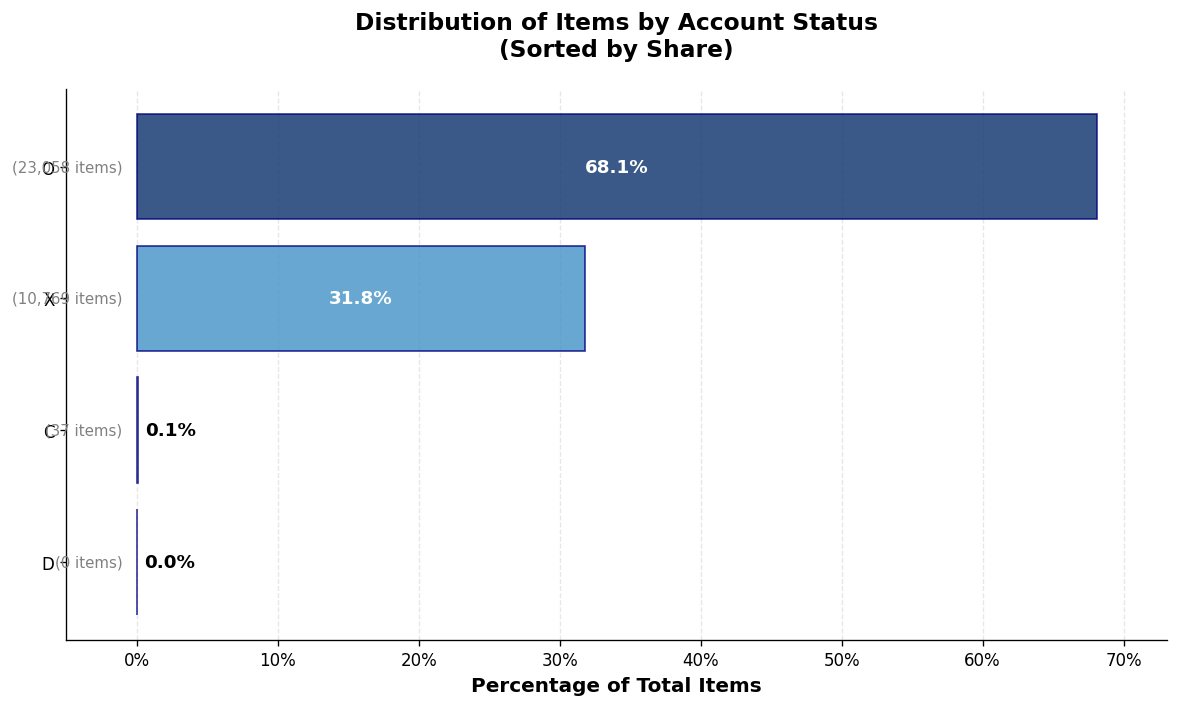


Top 3 Account Statuses by Item Volume:
  O: 68.1% (23,058 items)
  X: 31.8% (10,769 items)
  C: 0.1% (37 items)


In [19]:
# ---- Visualization 3: Item Share Distribution by Account Status ----

# Use the original summary data (excluding Grand Total)
chart_data = stat_code_summary[stat_code_summary['Account Status'] != 'Grand Total'].copy()

# Sort by % of Items for better visualization
chart_data_sorted = chart_data.sort_values('% of Items', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars with gradient effect
bars = ax.barh(
    chart_data_sorted['Account Status'], 
    chart_data_sorted['% of Items'], 
    color='#4472C4',
    alpha=0.8,
    edgecolor='navy',
    linewidth=1
)

# Color bars based on value (gradient effect)
for i, (bar, value) in enumerate(zip(bars, chart_data_sorted['% of Items'])):
    # Darker blue for higher percentages
    intensity = value / chart_data_sorted['% of Items'].max()
    bar.set_facecolor(plt.cm.Blues(0.3 + 0.7 * intensity))

# Add value labels
for i, (status, value) in enumerate(zip(chart_data_sorted['Account Status'], 
                                        chart_data_sorted['% of Items'])):
    # Position label inside bar if possible, outside if too small
    label_x = value + 0.5 if value < 5 else value / 2
    color = 'black' if value < 5 else 'white'
    
    ax.text(label_x, i, f'{value:.1f}%', 
            va='center', ha='left' if value < 5 else 'center',
            fontweight='bold', fontsize=11, color=color)
    
    # Add count info on the left
    count = chart_data_sorted[chart_data_sorted['Account Status'] == status]['# of Items'].values[0]
    ax.text(-1, i, f'({int(count):,} items)', 
            va='center', ha='right', fontsize=9, color='gray')

# Formatting
ax.set_xlabel('Percentage of Total Items', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Items by Account Status\n(Sorted by Share)', 
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis limits with some padding
ax.set_xlim(-5, max(chart_data_sorted['% of Items']) + 5)

# Format x-axis as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%' if x >= 0 else ''))

# Add vertical gridlines
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display and save
plt.show()
fig.savefig('item_share_by_status.png', dpi=300, bbox_inches='tight')
plt.close()

# Print top contributors
print("\nTop 3 Account Statuses by Item Volume:")
top_3 = chart_data_sorted.tail(3)
for _, row in top_3[::-1].iterrows():
    print(f"  {row['Account Status']}: {row['% of Items']:.1f}% ({int(row['# of Items']):,} items)")


## Print to excel

In [20]:
# ---- Export Analysis 1 to Master Report ----

# Prepare chart information
charts_info = [
    ('account_status_analysis.png', 'Chart 1: Accounts and Pay Ratio by Status'),
    ('item_disposition_by_status.png', 'Chart 2: Item Disposition (Paid vs Returned)'),
    ('item_share_by_status.png', 'Chart 3: Item Share Distribution')
]

# Add Analysis 1 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Account Status Analysis",
    data_df=stat_code_summary,
    charts=charts_info
)

print(f"\n✓ Analysis 1 complete and added to: {excel_path}")

✓ Added 'Account Status Analysis' to report

✓ Analysis 1 complete and added to: 1774 - ILS Kickoff Report Data-FEB26.xlsx


# Slide 2 
## Account Type

In [21]:
# ---- Analysis Two: Business vs Personal (Open Accounts) ----

# Helper: resolve column by aliases (case/space/underscore-insensitive)
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve all needed columns
acct_stat_col   = resolve_col(df, ["Acct Stat", "opstatus", "accountstatus", "acctstat"])
biz_flag_col    = resolve_col(df, ["Business?", "business", "businessflag"])
acctno_col      = resolve_col(df, ["AcctNo", "account number", "acctno", "accountno"])
total_items_col = resolve_col(df, ["Total Items", "items", "totalnsf"])
paid_items_col  = resolve_col(df, ["Paid Items", "numberofitemspaid", "# of Items Paid", "paid"])
deps_cnt_col    = resolve_col(df, ["# of Deposits", "deps", "nbrdeplastmonth", "number of deposits"])
deps_amt_col    = resolve_col(df, ["Monthly Deposits", "deps_amt", "amountdeplastmonth", "amount deposited in last month"])

# Validate criticals
crit = {
    "Acct Stat": acct_stat_col,
    "Business?": biz_flag_col,
    "AcctNo": acctno_col,
    "Total Items": total_items_col,
    "Paid Items": paid_items_col,
}
missing = [k for k, v in crit.items() if v is None]
if missing:
    raise KeyError(f"Missing required columns (any alias): {missing}")

# Coerce numerics where available
for c in [total_items_col, paid_items_col, deps_cnt_col, deps_amt_col]:
    if c is not None:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 1) Filter to open accounts (treat '0' as open)
df_open = df[df[acct_stat_col].astype(str) == "0"].copy()

# 2) Group by Business flag (keep NaN as a row)
agg_dict = {
    "# of Accounts": (acctno_col, "count"),
    "# of Items": (total_items_col, "sum"),
    "# of Paid Items": (paid_items_col, "sum"),
}
# Only add deposit fields if present
if deps_cnt_col is not None:
    agg_dict["Avg # of Deposits"] = (deps_cnt_col, "mean")
    agg_dict["Med # of Deposits"] = (deps_cnt_col, "median")
if deps_amt_col is not None:
    agg_dict["Avg $$ Deposits"] = (deps_amt_col, "mean")
    agg_dict["Med $$ Deposits"] = (deps_amt_col, "median")

acct_type_summary = (
    df_open.groupby(biz_flag_col, dropna=False)
           .agg(**agg_dict)
           .reset_index()
           .rename(columns={biz_flag_col: "Business?"})
)

acct_type_summary["Business?"] = acct_type_summary["Business?"].fillna("Unknown")

# 3) % columns and pay rate (safe)
tot_accts = acct_type_summary["# of Accounts"].sum()
tot_items = acct_type_summary["# of Items"].sum()
tot_paid  = acct_type_summary["# of Paid Items"].sum()

acct_type_summary["% of Accounts"] = (acct_type_summary["# of Accounts"] / max(tot_accts, 1) * 100)
acct_type_summary["% of Items"]    = (acct_type_summary["# of Items"] / max(tot_items, 1) * 100)
acct_type_summary["% Pay Rate"]    = (
    acct_type_summary["# of Paid Items"] / acct_type_summary["# of Items"].replace({0: pd.NA})
).fillna(0)

# 4) Column order (include optional cols only if present)
cols = ["Business?", "# of Accounts", "% of Accounts", "# of Items", "% of Items", "# of Paid Items", "% Pay Rate"]
if "Avg # of Deposits" in acct_type_summary.columns: cols += ["Avg # of Deposits", "Med # of Deposits"]
if "Avg $$ Deposits" in acct_type_summary.columns: cols += ["Avg $$ Deposits", "Med $$ Deposits"]
acct_type_summary = acct_type_summary[cols]

# 5) Grand Total row
grand = {
    "Business?": "Grand Total",
    "# of Accounts": tot_accts,
    "% of Accounts": 100.0 if tot_accts else 0.0,
    "# of Items": tot_items,
    "% of Items": 100.0 if tot_items else 0.0,
    "# of Paid Items": tot_paid,
    "% Pay Rate": (tot_paid / tot_items) if tot_items else 0.0,
}
if deps_cnt_col is not None:
    grand["Avg # of Deposits"] = df_open[deps_cnt_col].mean()
    grand["Med # of Deposits"] = df_open[deps_cnt_col].median()
if deps_amt_col is not None:
    grand["Avg $$ Deposits"] = df_open[deps_amt_col].mean()
    grand["Med $$ Deposits"] = df_open[deps_amt_col].median()

acct_type_summary = pd.concat([acct_type_summary, pd.DataFrame([grand])], ignore_index=True)

# 2. Store for later use
analysis_2_data = acct_type_summary.copy()

# 3. Add a summary print
print(f"\nBusiness vs Personal Summary (Open Accounts Only):")
print(f"Total Open Accounts: {tot_accts:,}")
print(f"Open Account Distribution:")
for _, row in acct_type_summary[acct_type_summary['Business?'] != 'Grand Total'].iterrows():
    print(f"  {row['Business?']}: {int(row['# of Accounts']):,} ({row['% of Accounts']:.1f}%)")

print(f"\n")
# 6) Display
styled = style_jupyter_table(acct_type_summary)
styled





Business vs Personal Summary (Open Accounts Only):
Total Open Accounts: 0
Open Account Distribution:




Business?,# of Accounts,% of Accounts,# of Items,% of Items,# of Paid Items,% Pay Rate
Grand Total,0,0.00%,0,0.00%,0,0%


## Chart - Account Type by Biz Flag

ValueError: Axis limits cannot be NaN or Inf

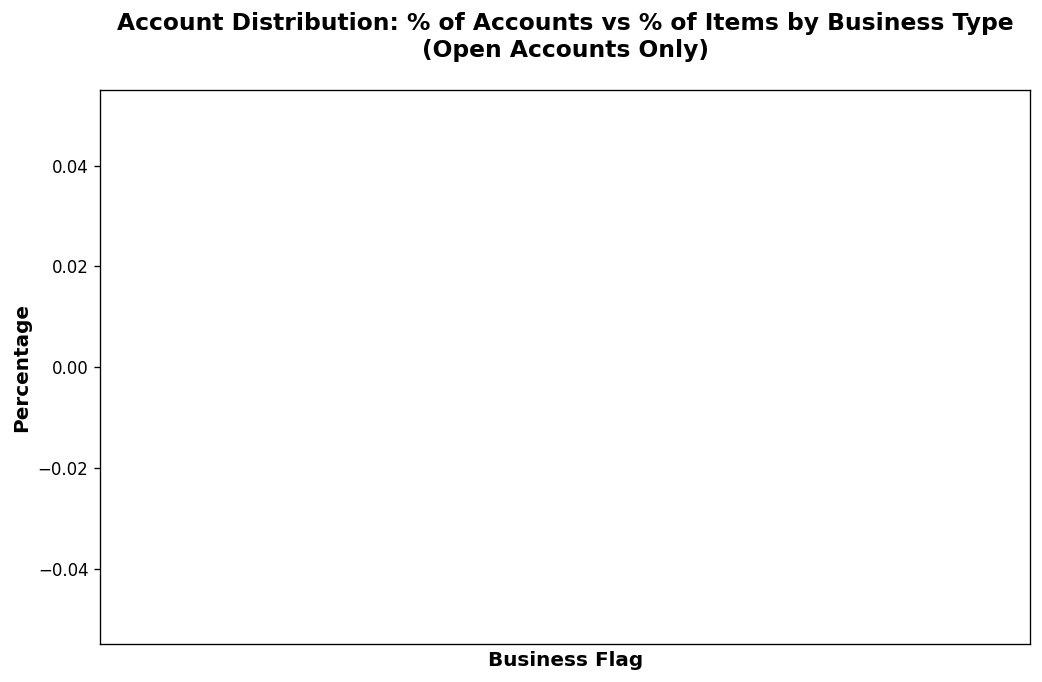

In [22]:
# ---- Visualization: % of Accounts vs % of Items by Business Flag ----

# Filter out Grand Total row
plot_df = acct_type_summary[acct_type_summary["Business?"] != "Grand Total"].copy()
plot_df = plot_df.sort_values("% of Accounts", ascending=False)

# Extract values
categories = plot_df["Business?"].astype(str)
acc_perc = plot_df["% of Accounts"]
item_perc = plot_df["% of Items"]

# Create figure
x = np.arange(len(categories))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars with professional colors
bars1 = ax.bar(x - width/2, acc_perc, width, 
                label="% of Accounts", 
                color='#4472C4', 
                alpha=0.8,
                edgecolor='navy',
                linewidth=1)

bars2 = ax.bar(x + width/2, item_perc, width, 
                label="% of Items", 
                color='#70AD47', 
                alpha=0.8,
                edgecolor='darkgreen',
                linewidth=1)

# Formatting
ax.set_ylabel("Percentage", fontsize=12, fontweight='bold')
ax.set_xlabel("Business Flag", fontsize=12, fontweight='bold')
ax.set_title("Account Distribution: % of Accounts vs % of Items by Business Type\n(Open Accounts Only)", 
             fontsize=14, fontweight='bold', pad=20)

# X-axis
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45 if len(categories) > 3 else 0, ha="right")

# Y-axis
ax.set_ylim(0, max(acc_perc.max(), item_perc.max()) * 1.15)  # Add headroom for labels
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Grid
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            ax.annotate(f'{height:.1f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', 
                       va='bottom', 
                       fontsize=10,
                       fontweight='bold')

# Legend
ax.legend(loc='upper right', 
          frameon=True, 
          fancybox=True, 
          shadow=True)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Save for Excel
fig.savefig('business_type_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Print insights
print("\nKey Insights:")
for _, row in plot_df.iterrows():
    acc_val = row['% of Accounts']
    item_val = row['% of Items']
    diff = item_val - acc_val
    
    print(f"{row['Business?']}:")
    print(f"  - {acc_val:.1f}% of accounts")
    print(f"  - {item_val:.1f}% of items")
    if abs(diff) > 5:
        if diff > 0:
            print(f"  → Generates disproportionately MORE items (+{diff:.1f}% points)")
        else:
            print(f"  → Generates disproportionately FEWER items ({diff:.1f}% points)")

## Print Analysis 2 to excel

In [ ]:
# ---- Export Analysis 2 to Master Report ----

# Prepare chart information
charts_info = [
    ('business_type_distribution.png', 'Business Type Distribution: Accounts vs Items')
]

# Add Analysis 2 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Business vs Personal",
    data_df=acct_type_summary,
    charts=charts_info
)

print(f"\n✓ Analysis 2 complete and added to: {excel_path}")

# Slide 3
## Personal Deposits

In [ ]:
# ---- Analysis 3: Personal Account Deposit Distribution ----

# Use the column resolution function from Analysis 2
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve columns
biz_col = resolve_col(df, ["Business?", "business", "businessflag"])
status_col = resolve_col(df, ["Account Status", "Acct Stat", "opstatus", "accountstatus"])
deps_cnt_col = resolve_col(df, ["Deposit Count", "# of Deposits", "deps", "nbrdeplastmonth"])
deps_amt_col = resolve_col(df, ["Deposit Amount", "Monthly Deposits", "deps_amt", "amountdeplastmonth"])
acct_col = resolve_col(df, ["AcctNo", "account number", "acctno"])

# Check if we have the required columns
if not all([biz_col, status_col, deps_cnt_col, deps_amt_col, acct_col]):
    print("Missing required columns. Found:")
    print(f"  Business: {biz_col}")
    print(f"  Status: {status_col}")
    print(f"  Deposit Count: {deps_cnt_col}")
    print(f"  Deposit Amount: {deps_amt_col}")
    print(f"  Account: {acct_col}")
else:
    # Filter to personal open accounts (0 = personal, 0 = open)
    personal_df = df[
        (df[biz_col].astype(str).isin(['0', 'P', 'Personal'])) & 
        (df[status_col].astype(str) == '0')
    ].copy()
    
    # Further filter to accounts with deposit data
    personal_df = personal_df[personal_df[deps_cnt_col].notna()]
    
    print(f"Found {len(personal_df):,} personal open accounts with deposit data")
    
    # Define bins for deposit frequency
    bins = [-1, 0, 1, 2, 5, 10, float("inf")]
    labels = ['0', '1', '2', '3–5', '6–10', '10+']
    personal_df['Deposit Bin'] = pd.cut(personal_df[deps_cnt_col], bins=bins, labels=labels)
    
    # Group and aggregate
    personal_deposit_summary = personal_df.groupby('Deposit Bin', observed=True).agg(
        Accounts=(acct_col, 'count'),
        Deposits=(deps_amt_col, 'mean'),
        Avg_Deposits=(deps_cnt_col, 'mean'),
        Med_Deposits=(deps_cnt_col, 'median')
    ).reset_index()
    
    # Add % of accounts
    personal_deposit_summary['% of Accounts'] = (
        personal_deposit_summary['Accounts'] / personal_deposit_summary['Accounts'].sum() * 100
    ).round(2)
    
    # Rename for clarity
    personal_deposit_summary = personal_deposit_summary.rename(columns={
        'Deposits': 'Avg $$ Deposits',
        'Avg_Deposits': 'Avg # of Deposits',
        'Med_Deposits': 'Med # of Deposits'
    })
    
    # Ensure account counts are clean integers
    personal_deposit_summary['Accounts'] = personal_deposit_summary['Accounts'].astype(int)
    
    # Reorder columns
    personal_deposit_summary = personal_deposit_summary[[
        'Deposit Bin', 'Accounts', '% of Accounts', 
        'Avg # of Deposits', 'Med # of Deposits', 'Avg $$ Deposits'
    ]]
    
    # Add Grand Total row
    personal_total = pd.DataFrame({
        'Deposit Bin': ['Grand Total'],
        'Accounts': [personal_deposit_summary['Accounts'].sum()],
        '% of Accounts': [100.0],
        'Avg # of Deposits': [personal_df[deps_cnt_col].mean()],
        'Med # of Deposits': [personal_df[deps_cnt_col].median()],
        'Avg $$ Deposits': [personal_df[deps_amt_col].mean()]
    })
    
    personal_deposit_summary = pd.concat([personal_deposit_summary, personal_total], ignore_index=True)
    
    # Round numeric columns
    personal_deposit_summary = personal_deposit_summary.round({
        'Avg # of Deposits': 2,
        'Med # of Deposits': 2,
        'Avg $$ Deposits': 2
    })
    
    # Display
    print("\nPersonal Account Deposit Distribution:")
    display(style_jupyter_table(personal_deposit_summary))
    
    # Store for later use
    analysis_3_data = personal_deposit_summary.copy()

## Visualization: Personal Account Deposit Distribution


In [ ]:
# ---- Visualization: Personal Account Deposit Distribution ----

# Filter out Grand Total
plot_data = personal_deposit_summary[personal_deposit_summary['Deposit Bin'] != 'Grand Total'].copy()

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars = ax.bar(
    plot_data['Deposit Bin'], 
    plot_data['% of Accounts'], 
    color='#4472C4',
    alpha=0.8,
    edgecolor='navy',
    linewidth=1
)

# Color gradient based on deposit frequency
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)

# Add value labels on bars
for i, (bin_label, pct) in enumerate(zip(plot_data['Deposit Bin'], plot_data['% of Accounts'])):
    # Add percentage on top
    ax.text(i, pct + 0.5, f'{pct:.1f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add count below percentage
    count = plot_data.iloc[i]['Accounts']
    ax.text(i, pct + 2, f'({count:,})', 
            ha='center', va='bottom', fontsize=9, color='gray')

# Formatting
ax.set_title('Personal Account Distribution by Monthly Deposit Frequency\n(Open Accounts Only)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Number of Deposits per Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Accounts', fontsize=12, fontweight='bold')

# Y-axis formatting
ax.set_ylim(0, max(plot_data['% of Accounts']) * 1.2)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Grid
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add mean line
mean_deposits = personal_df[deps_cnt_col].mean()
ax.axvline(x=-0.5, color='white', linewidth=0)  # Hidden line to extend x-axis
ax.text(len(plot_data) - 1, max(plot_data['% of Accounts']) * 1.1, 
        f'Mean: {mean_deposits:.1f} deposits/month', 
        ha='right', fontsize=10, style='italic', color='red')

plt.tight_layout()
plt.show()

# Save for Excel
fig.savefig('personal_deposit_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Print insights
print("\nKey Insights:")
print(f"Total Personal Accounts Analyzed: {plot_data['Accounts'].sum():,}")
print(f"Most common deposit frequency: {plot_data.loc[plot_data['% of Accounts'].idxmax(), 'Deposit Bin']}")
print(f"Accounts with 0 deposits: {plot_data[plot_data['Deposit Bin'] == '0']['% of Accounts'].values[0]:.1f}%")
if '10+' in plot_data['Deposit Bin'].values:
    high_freq = plot_data[plot_data['Deposit Bin'] == '10+']['% of Accounts'].values[0]
    print(f"High-frequency depositors (10+): {high_freq:.1f}%")

## Chart 3 - Print to excel 

In [ ]:
# ---- Export Analysis 3 to Master Report ----

# Prepare chart information
charts_info = [
   ('personal_deposit_distribution.png', 'Personal Account Distribution by Deposit Frequency')
]

# Add Analysis 3 to the report
add_analysis_to_report(
   report_path=excel_path,
   sheet_name="Personal Deposit Analysis",
   data_df=personal_deposit_summary,
   charts=charts_info
)

print(f"\n✓ Analysis 3 complete and added to: {excel_path}")

# Slide 4
## Business deposits

In [ ]:
# ---- Analysis 4: Business Account Deposit Distribution ----

# Use the column resolution function
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve columns
biz_col = resolve_col(df, ["Business?", "business", "businessflag"])
status_col = resolve_col(df, ["Account Status", "Acct Stat", "opstatus", "accountstatus"])
deps_cnt_col = resolve_col(df, ["Deposit Count", "# of Deposits", "deps", "nbrdeplastmonth"])
deps_amt_col = resolve_col(df, ["Deposit Amount", "Monthly Deposits", "deps_amt", "amountdeplastmonth"])
acct_col = resolve_col(df, ["AcctNo", "account number", "acctno"])

# Filter to business open accounts (1 = business, 0 = open)
business_df = df[
    (df[biz_col].astype(str).isin(['1', 'B', 'Business'])) & 
    (df[status_col].astype(str) == '0')
].copy()

# Further filter to accounts with deposit data
business_df = business_df[business_df[deps_cnt_col].notna()]

print(f"Found {len(business_df):,} business open accounts with deposit data")

# Define bins for deposit frequency
bins = [-1, 0, 1, 2, 5, 10, float("inf")]
labels = ['0', '1', '2', '3–5', '6–10', '10+']
business_df['Deposit Bin'] = pd.cut(business_df[deps_cnt_col], bins=bins, labels=labels)

# Group and aggregate
business_deposit_summary = business_df.groupby('Deposit Bin', observed=True).agg(
    Accounts=(acct_col, 'count'),
    Deposits=(deps_amt_col, 'mean'),
    Avg_Deposits=(deps_cnt_col, 'mean'),
    Med_Deposits=(deps_cnt_col, 'median')
).reset_index()

# Add % of accounts
business_deposit_summary['% of Accounts'] = (
    business_deposit_summary['Accounts'] / business_deposit_summary['Accounts'].sum() * 100
).round(2)

# Rename for clarity
business_deposit_summary = business_deposit_summary.rename(columns={
    'Deposits': 'Avg $$ Deposits',
    'Avg_Deposits': 'Avg # of Deposits',
    'Med_Deposits': 'Med # of Deposits'
})

# Ensure account counts are clean integers
business_deposit_summary['Accounts'] = business_deposit_summary['Accounts'].astype(int)

# Reorder columns
business_deposit_summary = business_deposit_summary[[
    'Deposit Bin', 'Accounts', '% of Accounts', 
    'Avg # of Deposits', 'Med # of Deposits', 'Avg $$ Deposits'
]]

# Add Grand Total row
business_total = pd.DataFrame({
    'Deposit Bin': ['Grand Total'],
    'Accounts': [business_deposit_summary['Accounts'].sum()],
    '% of Accounts': [100.0],
    'Avg # of Deposits': [business_df[deps_cnt_col].mean()],
    'Med # of Deposits': [business_df[deps_cnt_col].median()],
    'Avg $$ Deposits': [business_df[deps_amt_col].mean()]
})

business_deposit_summary = pd.concat([business_deposit_summary, business_total], ignore_index=True)

# Round numeric columns
business_deposit_summary = business_deposit_summary.round({
    'Avg # of Deposits': 2,
    'Med # of Deposits': 2,
    'Avg $$ Deposits': 2
})

# Display
print("\nBusiness Account Deposit Distribution:")
display(style_jupyter_table(business_deposit_summary))

# Store for later use
analysis_4_data = business_deposit_summary.copy()

## Visualization 4 - Business Account Deposit Distribution

In [ ]:
# ---- Visualization: Business Account Deposit Distribution ----

# Filter out Grand Total
plot_data = business_deposit_summary[business_deposit_summary['Deposit Bin'] != 'Grand Total'].copy()

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars = ax.bar(
    plot_data['Deposit Bin'], 
    plot_data['% of Accounts'], 
    color='#70AD47',  # Green for business
    alpha=0.8,
    edgecolor='darkgreen',
    linewidth=1
)

# Color gradient based on deposit frequency
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)

# Add value labels on bars
for i, (bin_label, pct) in enumerate(zip(plot_data['Deposit Bin'], plot_data['% of Accounts'])):
    # Add percentage on top
    ax.text(i, pct + 0.5, f'{pct:.1f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add count below percentage
    count = plot_data.iloc[i]['Accounts']
    ax.text(i, pct + 2, f'({count:,})', 
            ha='center', va='bottom', fontsize=9, color='gray')

# Formatting
ax.set_title('Business Account Distribution by Monthly Deposit Frequency\n(Open Accounts Only)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Number of Deposits per Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Accounts', fontsize=12, fontweight='bold')

# Y-axis formatting
ax.set_ylim(0, max(plot_data['% of Accounts']) * 1.2)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Grid
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add mean line
mean_deposits = business_df[deps_cnt_col].mean()
ax.text(len(plot_data) - 1, max(plot_data['% of Accounts']) * 1.1, 
        f'Mean: {mean_deposits:.1f} deposits/month', 
        ha='right', fontsize=10, style='italic', color='darkgreen')

plt.tight_layout()
plt.show()

# Save for Excel
fig.savefig('business_deposit_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Print insights
print("\nKey Insights:")
print(f"Total Business Accounts Analyzed: {plot_data['Accounts'].sum():,}")
print(f"Most common deposit frequency: {plot_data.loc[plot_data['% of Accounts'].idxmax(), 'Deposit Bin']}")
print(f"Accounts with 0 deposits: {plot_data[plot_data['Deposit Bin'] == '0']['% of Accounts'].values[0]:.1f}%")
if '10+' in plot_data['Deposit Bin'].values:
    high_freq = plot_data[plot_data['Deposit Bin'] == '10+']['% of Accounts'].values[0]
    print(f"High-frequency depositors (10+): {high_freq:.1f}%")

## Export Analysis 4 to Master Report ----


In [ ]:
# ---- Export Analysis 4 to Master Report ----

# Prepare chart information
charts_info = [
    ('business_deposit_distribution.png', 'Business Account Distribution by Deposit Frequency')
]

# Add Analysis 4 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Business Deposit Analysis",
    data_df=business_deposit_summary,
    charts=charts_info
)

print(f"\n✓ Analysis 4 complete and added to: {excel_path}")

# Slide 5 - NSF Stratification 1

## Personal NSF strat 1

In [ ]:
# ---- Analysis 5: Personal Account NSF/OD Item Stratification ----

# Use the column resolution function
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve columns
biz_col = resolve_col(df, ["Business?", "business", "businessflag"])
status_col = resolve_col(df, ["Account Status", "Acct Stat", "opstatus", "accountstatus"])
items_col = resolve_col(df, ["items", "Total Items", "totalitems", "totalnsf"])
acct_col = resolve_col(df, ["AcctNo", "account number", "acctno"])

# Filter to personal open accounts
personal_df_nsf = df[
    (df[biz_col].astype(str).isin(['0', 'P', 'Personal'])) & 
    (df[status_col].astype(str) == '0')
].copy()

print(f"Found {len(personal_df_nsf):,} personal open accounts")

# Define stratification bins
bins = [-1, 0, 6, 12, 24, 36, 48, float("inf")]
labels = ['0', '1–6', '7–12', '13–24', '25–36', '37–48', '49+']
personal_df_nsf['NSF Bin'] = pd.cut(personal_df_nsf[items_col], bins=bins, labels=labels)

# Group and summarize
nsf_strat1 = personal_df_nsf.groupby('NSF Bin', observed=True).agg(
    **{
        '# of Accounts': (acct_col, 'count'),
        'Total OD/NSF Items': (items_col, 'sum')
    }
).reset_index()

# Convert bin to string
nsf_strat1['NSF Bin'] = nsf_strat1['NSF Bin'].astype(str)

# Add percentage columns
total_accounts = nsf_strat1['# of Accounts'].sum()
total_items = nsf_strat1['Total OD/NSF Items'].sum()

nsf_strat1['% of Accounts'] = (nsf_strat1['# of Accounts'] / total_accounts * 100).round(2)
nsf_strat1['% of Items Presented'] = (nsf_strat1['Total OD/NSF Items'] / total_items * 100).round(2)

# Add Grand Total row
grand_total = pd.DataFrame([{
    'NSF Bin': 'Grand Total',
    '# of Accounts': total_accounts,
    '% of Accounts': 100.0,
    'Total OD/NSF Items': total_items,
    '% of Items Presented': 100.0
}])

nsf_strat1 = pd.concat([nsf_strat1, grand_total], ignore_index=True)
nsf_strat1['# of Accounts'] = nsf_strat1['# of Accounts'].astype(int)
nsf_strat1['Total OD/NSF Items'] = nsf_strat1['Total OD/NSF Items'].astype(int)

# Final column order
nsf_strat1 = nsf_strat1[[
    'NSF Bin', '# of Accounts', '% of Accounts',
    'Total OD/NSF Items', '% of Items Presented'
]]

# Display
print("\nPersonal Account NSF/OD Item Stratification:")
display(style_jupyter_table(nsf_strat1))

# Store for later use
analysis_5_data = nsf_strat1.copy()

## Chart Analysis 5

In [ ]:
# ---- Visualization: NSF/OD Item Distribution ----

# Filter out Grand Total
plot_data = nsf_strat1[nsf_strat1['NSF Bin'] != 'Grand Total'].copy()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Left plot: Account Distribution ---
x_pos = np.arange(len(plot_data))
bars1 = ax1.bar(
    x_pos, 
    plot_data['% of Accounts'],
    color='#4472C4',
    alpha=0.8,
    edgecolor='navy',
    linewidth=1,
    width=0.6
)

# Add value labels - only on top of bars
for i, pct in enumerate(plot_data['% of Accounts']):
    if pct > 2:  # Only label bars > 2%
        ax1.text(i, pct + 1, f'{pct:.1f}%', 
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_title('Account Distribution by NSF/OD Items', fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('NSF/OD Item Bins', fontsize=12, labelpad=10)
ax1.set_ylabel('% of Accounts', fontsize=12)
ax1.set_ylim(0, 105)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Set x-axis
ax1.set_xticks(x_pos)
ax1.set_xticklabels(plot_data['NSF Bin'], rotation=0, fontsize=11)

# --- Right plot: Item Distribution ---
bars2 = ax2.bar(
    x_pos, 
    plot_data['% of Items Presented'],
    color='#C00000',
    alpha=0.8,
    edgecolor='darkred',
    linewidth=1,
    width=0.6
)

# Add value labels - only on top of bars
for i, pct in enumerate(plot_data['% of Items Presented']):
    if pct > 2:  # Only label bars > 2%
        ax2.text(i, pct + 1, f'{pct:.1f}%', 
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2.set_title('Item Distribution by NSF/OD Items', fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('NSF/OD Item Bins', fontsize=12, labelpad=10)
ax2.set_ylabel('% of Total Items', fontsize=12)
ax2.set_ylim(0, max(plot_data['% of Items Presented']) * 1.15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Set x-axis
ax2.set_xticks(x_pos)
ax2.set_xticklabels(plot_data['NSF Bin'], rotation=0, fontsize=11)

# Overall title
fig.suptitle('Personal Account NSF/OD Item Analysis\n(Open Accounts Only)', 
             fontsize=15, fontweight='bold', y=0.98)

# Remove top and right spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axisbelow(True)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save for Excel
fig.savefig('personal_nsf_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Print insights with account counts
print("\nKey Insights:")
zero_nsf_pct = plot_data[plot_data['NSF Bin'] == '0']['% of Accounts'].values[0]
zero_nsf_cnt = plot_data[plot_data['NSF Bin'] == '0']['# of Accounts'].values[0]
print(f"Accounts with NO NSF/OD items: {zero_nsf_pct:.1f}% ({zero_nsf_cnt:,} accounts)")

high_nsf_data = plot_data[plot_data['NSF Bin'].isin(['37–48', '49+'])]
high_nsf_pct = high_nsf_data['% of Accounts'].sum()
high_nsf_cnt = high_nsf_data['# of Accounts'].sum()
print(f"High-frequency NSF accounts (37+ items): {high_nsf_pct:.1f}% ({high_nsf_cnt:,} accounts)")

# Concentration analysis
top_2_bins = plot_data.nlargest(2, '% of Items Presented')
top_2_items_pct = top_2_bins['% of Items Presented'].sum()
print(f"Top 2 bins ({', '.join(top_2_bins['NSF Bin'].values)}) account for {top_2_items_pct:.1f}% of all NSF/OD items")

## Export Analysis 5 to Master Report


In [ ]:
# ---- Export Analysis 5 to Master Report ----

# Prepare chart information
charts_info = [
    ('personal_nsf_distribution.png', 'Personal Account NSF/OD Distribution Analysis')
]

# Add Analysis 5 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Personal NSF Analysis",
    data_df=nsf_strat1,
    charts=charts_info
)

print(f"\n✓ Analysis 5 complete and added to: {excel_path}")

# Slide 6

## Business NSF strat 1

In [ ]:
# ---- Analysis 6: Business Account NSF/OD Item Stratification ----

# Use the column resolution function
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve columns
biz_col = resolve_col(df, ["Business?", "business", "businessflag"])
status_col = resolve_col(df, ["Account Status", "Acct Stat", "opstatus", "accountstatus"])
items_col = resolve_col(df, ["items", "Total Items", "totalitems", "totalnsf"])
acct_col = resolve_col(df, ["AcctNo", "account number", "acctno"])

# Filter to business open accounts
business_df_nsf = df[
    (df[biz_col].astype(str).isin(['1', 'B', 'Business'])) & 
    (df[status_col].astype(str) == '0')
].copy()

print(f"Found {len(business_df_nsf):,} business open accounts")

# Define stratification bins
bins = [-1, 0, 6, 12, 24, 36, 48, float("inf")]
labels = ['0', '1–6', '7–12', '13–24', '25–36', '37–48', '49+']
business_df_nsf['NSF Bin'] = pd.cut(business_df_nsf[items_col], bins=bins, labels=labels)

# Group and summarize
nsf_strat_business = business_df_nsf.groupby('NSF Bin', observed=True).agg(
    **{
        '# of Accounts': (acct_col, 'count'),
        'Total OD/NSF Items': (items_col, 'sum')
    }
).reset_index()

# Convert bin to string
nsf_strat_business['NSF Bin'] = nsf_strat_business['NSF Bin'].astype(str)

# Add percentage columns
total_accounts = nsf_strat_business['# of Accounts'].sum()
total_items = nsf_strat_business['Total OD/NSF Items'].sum()

nsf_strat_business['% of Accounts'] = (nsf_strat_business['# of Accounts'] / total_accounts * 100).round(2)
nsf_strat_business['% of Items Presented'] = (nsf_strat_business['Total OD/NSF Items'] / total_items * 100).round(2)

# Add Grand Total row
grand_total = pd.DataFrame([{
    'NSF Bin': 'Grand Total',
    '# of Accounts': total_accounts,
    '% of Accounts': 100.0,
    'Total OD/NSF Items': total_items,
    '% of Items Presented': 100.0
}])

nsf_strat_business = pd.concat([nsf_strat_business, grand_total], ignore_index=True)
nsf_strat_business['# of Accounts'] = nsf_strat_business['# of Accounts'].astype(int)
nsf_strat_business['Total OD/NSF Items'] = nsf_strat_business['Total OD/NSF Items'].astype(int)

# Final column order
nsf_strat_business = nsf_strat_business[[
    'NSF Bin', '# of Accounts', '% of Accounts',
    'Total OD/NSF Items', '% of Items Presented'
]]

# Display
print("\nBusiness Account NSF/OD Item Stratification:")
display(style_jupyter_table(nsf_strat_business))

# Store for later use
analysis_6_data = nsf_strat_business.copy()

## Chart 6 - Business NSF/OD Item Distribution ----


In [ ]:
# ---- Visualization: Business NSF/OD Item Distribution ----

# Filter out Grand Total
plot_data = nsf_strat_business[nsf_strat_business['NSF Bin'] != 'Grand Total'].copy()

# Single figure with stacked layout
fig, ax = plt.subplots(figsize=(12, 8))

# Set up bar positions
x_pos = np.arange(len(plot_data))
bar_width = 0.35

# Create bars for accounts
bars1 = ax.bar(x_pos - bar_width/2, plot_data['% of Accounts'], 
                bar_width, label='% of Accounts', 
                color='#70AD47', alpha=0.8, edgecolor='darkgreen')

# Create bars for items
bars2 = ax.bar(x_pos + bar_width/2, plot_data['% of Items Presented'], 
                bar_width, label='% of Items', 
                color='#FFC000', alpha=0.8, edgecolor='#CC9900')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 1:  # Only label if > 1%
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                   f'{height:.1f}%', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')

# Formatting
ax.set_title('Business Account NSF/OD Distribution\n(% of Accounts vs % of Items)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('NSF/OD Item Bins', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=13, fontweight='bold')

# X-axis
ax.set_xticks(x_pos)
ax.set_xticklabels(plot_data['NSF Bin'], fontsize=12)

# Y-axis
ax.set_ylim(0, max(plot_data[['% of Accounts', '% of Items Presented']].max()) * 1.15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Grid and styling
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)

# Add annotation for key insight
zero_accounts = plot_data[plot_data['NSF Bin'] == '0']['% of Accounts'].values[0]
ax.text(0.02, 0.95, f'{zero_accounts:.1f}% of business accounts\nhave NO NSF/OD items', 
        transform=ax.transAxes, fontsize=11, 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        verticalalignment='top')

plt.tight_layout()
plt.show()

# Save for Excel
fig.savefig('business_nsf_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Print insights
print("\nKey Insights:")
print(f"Business accounts with NO NSF/OD items: {zero_accounts:.1f}%")

high_nsf = plot_data[plot_data['NSF Bin'].isin(['37–48', '49+'])]['% of Accounts'].sum()
print(f"High-frequency NSF business accounts (37+ items): {high_nsf:.1f}%")

# Compare to personal if available
if 'analysis_5_data' in globals():
    personal_zero = analysis_5_data[analysis_5_data['NSF Bin'] == '0']['% of Accounts'].values[0]
    print(f"\nComparison: Personal accounts with NO NSF/OD: {personal_zero:.1f}%")
    print(f"Difference: Business has {abs(zero_accounts - personal_zero):.1f}% {'more' if zero_accounts > personal_zero else 'fewer'} zero-NSF accounts")

## Chart Analysis 6


In [ ]:
# ---- Export Analysis 6 to Master Report ----

# Prepare chart information
charts_info = [
    ('business_nsf_distribution.png', 'Business Account NSF/OD Distribution Analysis')
]

# Add Analysis 6 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Business NSF Analysis",
    data_df=nsf_strat_business,
    charts=charts_info
)

print(f"\n✓ Analysis 6 complete and added to: {excel_path}")

# Slide 7 - NSF Stratification 2 with pay ratio

## Personal stratification

In [ ]:
# ---- Analysis 7: Personal NSF Stratification with Pay Ratio ----

# Use the column resolution function
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve columns
biz_col = resolve_col(df, ["Business?", "business", "businessflag"])
status_col = resolve_col(df, ["Account Status", "Acct Stat", "opstatus", "accountstatus"])
items_col = resolve_col(df, ["items", "Total Items", "totalitems", "totalnsf"])
paid_col = resolve_col(df, ["paid", "Paid Items", "paiditems"])
acct_col = resolve_col(df, ["AcctNo", "account number", "acctno"])

# Filter to personal open accounts
personal_open_df = df[
    (df[biz_col].astype(str).isin(['0', 'P', 'Personal'])) & 
    (df[status_col].astype(str) == '0')
].copy()

# Further filter to accounts with items data
personal_open_df = personal_open_df[personal_open_df[items_col].notna()]

print(f"Found {len(personal_open_df):,} personal open accounts with item data")

# Define NSF binning
nsf_bins = [-1, 0, 6, 12, 24, 36, 48, float("inf")]
nsf_labels = ['0', '1–6', '7–12', '13–24', '25–36', '37–48', '49+']
personal_open_df['NSF Bin'] = pd.cut(personal_open_df[items_col], bins=nsf_bins, labels=nsf_labels)

# Group and summarize
nsf_strat_personal = personal_open_df.groupby('NSF Bin', observed=True).agg(
    **{
        '# of Accounts': (acct_col, 'count'),
        'Total OD/NSF Items': (items_col, 'sum'),
        '# of Items Paid': (paid_col, 'sum')
    }
).reset_index()

# Compute percentages and pay ratio
total_accounts = nsf_strat_personal['# of Accounts'].sum()
total_items = nsf_strat_personal['Total OD/NSF Items'].sum()

nsf_strat_personal['% of Accounts'] = (nsf_strat_personal['# of Accounts'] / total_accounts * 100).round(2)
nsf_strat_personal['% of Items Presented'] = (nsf_strat_personal['Total OD/NSF Items'] / total_items * 100).round(2)

# Safe pay ratio calculation
nsf_strat_personal['Pay Ratio'] = np.where(
    nsf_strat_personal['Total OD/NSF Items'] > 0,
    (nsf_strat_personal['# of Items Paid'] / nsf_strat_personal['Total OD/NSF Items']).round(4),
    0
)

# Add Grand Total
personal_total_paid = nsf_strat_personal['# of Items Paid'].sum()
grand_total_personal = pd.DataFrame([{
    'NSF Bin': 'Grand Total',
    '# of Accounts': total_accounts,
    '% of Accounts': 100.0,
    'Total OD/NSF Items': total_items,
    '% of Items Presented': 100.0,
    '# of Items Paid': personal_total_paid,
    'Pay Ratio': round(personal_total_paid / total_items, 4) if total_items > 0 else 0
}])

# Combine & finalize
nsf_strat_personal['NSF Bin'] = nsf_strat_personal['NSF Bin'].astype(str)
nsf_strat_personal = pd.concat([nsf_strat_personal, grand_total_personal], ignore_index=True)
nsf_strat_personal['# of Accounts'] = nsf_strat_personal['# of Accounts'].astype(int)
nsf_strat_personal['Total OD/NSF Items'] = nsf_strat_personal['Total OD/NSF Items'].astype(int)
nsf_strat_personal['# of Items Paid'] = nsf_strat_personal['# of Items Paid'].astype(int)

# Display
print("\nPersonal NSF Stratification with Pay Ratios:")
display(style_jupyter_table(nsf_strat_personal))

# Store for later use
analysis_7_data = nsf_strat_personal.copy()

## Chart 7 - Personal NSF Stratification 2 with pay ratio

In [ ]:
# ---- Visualization: Personal NSF Pay Ratio Analysis ----

# Filter out Grand Total
plot_data = nsf_strat_personal[nsf_strat_personal['NSF Bin'] != 'Grand Total'].copy()

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar chart for % of Items
bars = ax1.bar(plot_data['NSF Bin'], plot_data['% of Items Presented'], 
                color='#4472C4', alpha=0.8, label='% of Items',
                edgecolor='navy', linewidth=1)

# Add value labels on bars
for i, (bar, pct) in enumerate(zip(bars, plot_data['% of Items Presented'])):
    if pct > 1:  # Only label if > 1%
        ax1.text(bar.get_x() + bar.get_width()/2, pct + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

# Primary y-axis
ax1.set_xlabel('NSF/OD Item Bins', fontsize=12, fontweight='bold')
ax1.set_ylabel('% of Total Items', fontsize=12, fontweight='bold', color='#4472C4')
ax1.tick_params(axis='y', labelcolor='#4472C4')
ax1.set_ylim(0, max(plot_data['% of Items Presented']) * 1.2)

# Secondary y-axis for Pay Ratio
ax2 = ax1.twinx()
line = ax2.plot(plot_data['NSF Bin'], plot_data['Pay Ratio'] * 100, 
                color='#C00000', marker='o', linewidth=2.5, markersize=8,
                label='Pay Ratio (%)', markeredgecolor='darkred', markeredgewidth=1)

# Add value labels on line
for i, (bin_label, ratio) in enumerate(zip(plot_data['NSF Bin'], plot_data['Pay Ratio'] * 100)):
    ax2.text(i, ratio + 1, f'{ratio:.1f}%', 
            ha='center', va='bottom', fontsize=9, 
            fontweight='bold', color='#C00000')

# Secondary y-axis
ax2.set_ylabel('Pay Ratio (%)', fontsize=12, fontweight='bold', color='#C00000')
ax2.tick_params(axis='y', labelcolor='#C00000')
ax2.set_ylim(0, 110)

# Title
ax1.set_title('Personal Account NSF/OD Analysis: Item Distribution & Pay Ratios\n(Open Accounts Only)', 
              fontsize=14, fontweight='bold', pad=20)

# Grid and styling
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True)

# Add key insight box
overall_pay_ratio = nsf_strat_personal[nsf_strat_personal['NSF Bin'] == 'Grand Total']['Pay Ratio'].values[0]
ax1.text(0.98, 0.95, f'Overall Pay Ratio: {overall_pay_ratio:.1%}', 
         transform=ax1.transAxes, fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7),
         verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

# Save for Excel
fig.savefig('personal_nsf_pay_ratio.png', dpi=300, bbox_inches='tight')
plt.close()

# Print insights
print("\nKey Insights:")
print(f"Overall Pay Ratio for Personal Accounts: {overall_pay_ratio:.1%}")
print("\nPay Ratio by NSF Bin:")
for _, row in plot_data.iterrows():
    print(f"  {row['NSF Bin']:6} items: {row['Pay Ratio']:.1%} pay ratio ({row['# of Accounts']:,} accounts)")

## Export 7 - Personal NSF Stratification 2 with pay ratio

In [ ]:
# ---- Export Analysis 7 to Master Report ----

# Prepare chart information
charts_info = [
    ('personal_nsf_pay_ratio.png', 'Personal NSF Pay Ratio Analysis')
]

# Add Analysis 7 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Personal NSF Pay Ratio",
    data_df=nsf_strat_personal,
    charts=charts_info
)

print(f"\n✓ Analysis 7 complete and added to: {excel_path}")

# Slide 8 - NSF Business Stratifiction with pay ratio

In [ ]:
# ---- Analysis 8: Business NSF Stratification with Pay Ratio ----

# Use the column resolution function
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve columns
biz_col = resolve_col(df, ["Business?", "business", "businessflag"])
status_col = resolve_col(df, ["Account Status", "Acct Stat", "opstatus", "accountstatus"])
items_col = resolve_col(df, ["items", "Total Items", "totalitems", "totalnsf"])
paid_col = resolve_col(df, ["paid", "Paid Items", "paiditems"])
acct_col = resolve_col(df, ["AcctNo", "account number", "acctno"])

# Filter to business open accounts
business_open_df = df[
    (df[biz_col].astype(str).isin(['1', 'B', 'Business'])) & 
    (df[status_col].astype(str) == '0')
].copy()

# Further filter to accounts with items data
business_open_df = business_open_df[business_open_df[items_col].notna()]

print(f"Found {len(business_open_df):,} business open accounts with item data")

# Define NSF binning
nsf_bins = [-1, 0, 6, 12, 24, 36, 48, float("inf")]
nsf_labels = ['0', '1–6', '7–12', '13–24', '25–36', '37–48', '49+']
business_open_df['NSF Bin'] = pd.cut(business_open_df[items_col], bins=nsf_bins, labels=nsf_labels)

# Group and summarize
nsf_strat_business = business_open_df.groupby('NSF Bin', observed=True).agg(
    **{
        '# of Accounts': (acct_col, 'count'),
        'Total OD/NSF Items': (items_col, 'sum'),
        '# of Items Paid': (paid_col, 'sum')
    }
).reset_index()

# Compute percentages and pay ratio
total_accounts = nsf_strat_business['# of Accounts'].sum()
total_items = nsf_strat_business['Total OD/NSF Items'].sum()

nsf_strat_business['% of Accounts'] = (nsf_strat_business['# of Accounts'] / total_accounts * 100).round(2)
nsf_strat_business['% of Items Presented'] = (nsf_strat_business['Total OD/NSF Items'] / total_items * 100).round(2)

# Safe pay ratio calculation
nsf_strat_business['Pay Ratio'] = np.where(
    nsf_strat_business['Total OD/NSF Items'] > 0,
    (nsf_strat_business['# of Items Paid'] / nsf_strat_business['Total OD/NSF Items']).round(4),
    0
)

# Add Grand Total
business_total_paid = nsf_strat_business['# of Items Paid'].sum()
grand_total_business = pd.DataFrame([{
    'NSF Bin': 'Grand Total',
    '# of Accounts': total_accounts,
    '% of Accounts': 100.0,
    'Total OD/NSF Items': total_items,
    '% of Items Presented': 100.0,
    '# of Items Paid': business_total_paid,
    'Pay Ratio': round(business_total_paid / total_items, 4) if total_items > 0 else 0
}])

# Combine & finalize
nsf_strat_business['NSF Bin'] = nsf_strat_business['NSF Bin'].astype(str)
nsf_strat_business = pd.concat([nsf_strat_business, grand_total_business], ignore_index=True)
nsf_strat_business['# of Accounts'] = nsf_strat_business['# of Accounts'].astype(int)
nsf_strat_business['Total OD/NSF Items'] = nsf_strat_business['Total OD/NSF Items'].astype(int)
nsf_strat_business['# of Items Paid'] = nsf_strat_business['# of Items Paid'].astype(int)

# Display
print("\nBusiness NSF Stratification with Pay Ratios:")
display(style_jupyter_table(nsf_strat_business))

# Store for later use
analysis_8_data = nsf_strat_business.copy()

## Chart 8 

In [ ]:
# ---- Visualization: Business NSF Pay Ratio Analysis ----

# Filter out Grand Total
plot_data = nsf_strat_business[nsf_strat_business['NSF Bin'] != 'Grand Total'].copy()

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar chart for % of Items
bars = ax1.bar(plot_data['NSF Bin'], plot_data['% of Items Presented'], 
                color='#70AD47', alpha=0.8, label='% of Items',
                edgecolor='darkgreen', linewidth=1)

# Add value labels on bars
for i, (bar, pct) in enumerate(zip(bars, plot_data['% of Items Presented'])):
    if pct > 1:  # Only label if > 1%
        ax1.text(bar.get_x() + bar.get_width()/2, pct + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

# Primary y-axis
ax1.set_xlabel('NSF/OD Item Bins', fontsize=12, fontweight='bold')
ax1.set_ylabel('% of Total Items', fontsize=12, fontweight='bold', color='#70AD47')
ax1.tick_params(axis='y', labelcolor='#70AD47')
ax1.set_ylim(0, max(plot_data['% of Items Presented']) * 1.2)

# Secondary y-axis for Pay Ratio
ax2 = ax1.twinx()
line = ax2.plot(plot_data['NSF Bin'], plot_data['Pay Ratio'] * 100, 
                color='#C00000', marker='o', linewidth=2.5, markersize=8,
                label='Pay Ratio (%)', markeredgecolor='darkred', markeredgewidth=1)

# Add value labels on line
for i, (bin_label, ratio) in enumerate(zip(plot_data['NSF Bin'], plot_data['Pay Ratio'] * 100)):
    ax2.text(i, ratio + 1, f'{ratio:.1f}%', 
            ha='center', va='bottom', fontsize=9, 
            fontweight='bold', color='#C00000')

# Secondary y-axis
ax2.set_ylabel('Pay Ratio (%)', fontsize=12, fontweight='bold', color='#C00000')
ax2.tick_params(axis='y', labelcolor='#C00000')
ax2.set_ylim(0, 110)

# Title
ax1.set_title('Business Account NSF/OD Analysis: Item Distribution & Pay Ratios\n(Open Accounts Only)', 
              fontsize=14, fontweight='bold', pad=20)

# Grid and styling
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True)

# Add key insight box
overall_pay_ratio = nsf_strat_business[nsf_strat_business['NSF Bin'] == 'Grand Total']['Pay Ratio'].values[0]
ax1.text(0.98, 0.95, f'Overall Pay Ratio: {overall_pay_ratio:.1%}', 
         transform=ax1.transAxes, fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7),
         verticalalignment='top', horizontalalignment='right')

# Add comparison to personal if available
if 'analysis_7_data' in globals():
    personal_ratio = analysis_7_data[analysis_7_data['NSF Bin'] == 'Grand Total']['Pay Ratio'].values[0]
    diff = overall_pay_ratio - personal_ratio
    ax1.text(0.98, 0.85, f'vs Personal: {diff:+.1%}', 
             transform=ax1.transAxes, fontsize=10, 
             color='darkgreen' if diff > 0 else 'darkred',
             verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

# Save for Excel
fig.savefig('business_nsf_pay_ratio.png', dpi=300, bbox_inches='tight')
plt.close()

# Print insights
print("\nKey Insights:")
print(f"Overall Pay Ratio for Business Accounts: {overall_pay_ratio:.1%}")
print("\nPay Ratio by NSF Bin:")
for _, row in plot_data.iterrows():
    print(f"  {row['NSF Bin']:6} items: {row['Pay Ratio']:.1%} pay ratio ({row['# of Accounts']:,} accounts)")

# Compare to personal if available
if 'analysis_7_data' in globals():
    print(f"\nPersonal Overall Pay Ratio: {personal_ratio:.1%}")
    print(f"Business pays {diff:+.1%} {'better' if diff > 0 else 'worse'} than Personal")

## Export 8

In [ ]:
# ---- Export Analysis 8 to Master Report ----

# Prepare chart information
charts_info = [
    ('business_nsf_pay_ratio.png', 'Business NSF Pay Ratio Analysis')
]

# Add Analysis 8 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Business NSF Pay Ratio",
    data_df=nsf_strat_business,
    charts=charts_info
)

print(f"\n✓ Analysis 8 complete and added to: {excel_path}")

# Slide 9 - Personal NSF Stratification3 - with deps

In [ ]:
# ---- Analysis 9: Personal NSF Stratification with Deposit & Swipe Metrics ----

# Use the column resolution function
def resolve_col(df, aliases):
    norm = lambda s: s.strip().lower().replace(" ", "").replace("_", "")
    cols_norm = {norm(c): c for c in df.columns}
    for a in aliases:
        if norm(a) in cols_norm:
            return cols_norm[norm(a)]
    return None

# Resolve columns
biz_col = resolve_col(df, ["Business?", "business", "businessflag"])
status_col = resolve_col(df, ["Account Status", "Acct Stat", "opstatus", "accountstatus"])
items_col = resolve_col(df, ["items", "Total Items", "totalitems", "totalnsf"])
paid_col = resolve_col(df, ["paid", "Paid Items", "paiditems"])
acct_col = resolve_col(df, ["AcctNo", "account number", "acctno"])
deps_cnt_col = resolve_col(df, ["Deposit Count", "# of Deposits", "deps", "nbrdeplastmonth"])
deps_amt_col = resolve_col(df, ["Deposit Amount", "Monthly Deposits", "deps_amt", "amountdeplastmonth"])
od_limit_col = resolve_col(df, ["OD Limit", "overdraftlimit", "odlimit", "limitod"])
swipes_col = resolve_col(df, ["Swipes", "swipes", "trancount"])

# Filter to personal open accounts
personal_open_df = df[
    (df[biz_col].astype(str).isin(['0', 'P', 'Personal'])) & 
    (df[status_col].astype(str) == '0')
].copy()

# Further filter to accounts with items data
personal_open_df = personal_open_df[personal_open_df[items_col].notna()]

print(f"Found {len(personal_open_df):,} personal open accounts with item data")

# Define stratification bins
nsf_bins = [-1, 0, 6, 12, 24, 36, 48, float("inf")]
nsf_labels = ['0', '1–6', '7–12', '13–24', '25–36', '37–48', '49+']
personal_open_df['NSF Bin'] = pd.cut(personal_open_df[items_col], bins=nsf_bins, labels=nsf_labels)

# Group and summarize
agg_dict = {
    '# of Accounts': (acct_col, 'count'),
    'Total OD/NSF Items': (items_col, 'sum'),
    '# of Items Paid': (paid_col, 'sum')
}

# Add optional metrics if columns exist
if deps_cnt_col:
    agg_dict['Avg # Dep/Month'] = (deps_cnt_col, 'mean')
if deps_amt_col:
    agg_dict['Avg $$ Dep/Month'] = (deps_amt_col, 'mean')
if od_limit_col:
    agg_dict['Average of OD Limit'] = (od_limit_col, 'mean')
if swipes_col:
    agg_dict['Average of Swipes'] = (swipes_col, 'mean')

nsf_strat_personal_deposits = personal_open_df.groupby('NSF Bin', observed=True).agg(**agg_dict).reset_index()

# Calculate percentages and pay ratio
total_accounts = nsf_strat_personal_deposits['# of Accounts'].sum()
total_items = nsf_strat_personal_deposits['Total OD/NSF Items'].sum()

nsf_strat_personal_deposits['% of Accounts'] = (
    nsf_strat_personal_deposits['# of Accounts'] / total_accounts * 100
).round(2)
nsf_strat_personal_deposits['% of Items Presented'] = (
    nsf_strat_personal_deposits['Total OD/NSF Items'] / total_items * 100
).round(2)
nsf_strat_personal_deposits['Pay Ratio'] = np.where(
    nsf_strat_personal_deposits['Total OD/NSF Items'] > 0,
    (nsf_strat_personal_deposits['# of Items Paid'] / nsf_strat_personal_deposits['Total OD/NSF Items']).round(4),
    0
)

# Grand Total row
personal_total_paid = nsf_strat_personal_deposits['# of Items Paid'].sum()
grand_total_dict = {
    'NSF Bin': 'Grand Total',
    '# of Accounts': total_accounts,
    '% of Accounts': 100.0,
    'Total OD/NSF Items': total_items,
    '% of Items Presented': 100.0,
    '# of Items Paid': personal_total_paid,
    'Pay Ratio': round(personal_total_paid / total_items, 4) if total_items > 0 else 0
}

# Add averages to grand total if columns exist
if deps_cnt_col and 'Avg # Dep/Month' in nsf_strat_personal_deposits.columns:
    grand_total_dict['Avg # Dep/Month'] = personal_open_df[deps_cnt_col].mean()
if deps_amt_col and 'Avg $$ Dep/Month' in nsf_strat_personal_deposits.columns:
    grand_total_dict['Avg $$ Dep/Month'] = personal_open_df[deps_amt_col].mean()
if od_limit_col and 'Average of OD Limit' in nsf_strat_personal_deposits.columns:
    grand_total_dict['Average of OD Limit'] = personal_open_df[od_limit_col].mean()
if swipes_col and 'Average of Swipes' in nsf_strat_personal_deposits.columns:
    grand_total_dict['Average of Swipes'] = personal_open_df[swipes_col].mean()

grand_total_personal = pd.DataFrame([grand_total_dict])

# Finalize table
nsf_strat_personal_deposits = pd.concat([nsf_strat_personal_deposits, grand_total_personal], ignore_index=True)
nsf_strat_personal_deposits['# of Accounts'] = nsf_strat_personal_deposits['# of Accounts'].astype(int)
nsf_strat_personal_deposits['NSF Bin'] = nsf_strat_personal_deposits['NSF Bin'].astype(str)

# Round numeric columns
for col in ['Avg # Dep/Month', 'Avg $$ Dep/Month', 'Average of OD Limit', 'Average of Swipes']:
    if col in nsf_strat_personal_deposits.columns:
        nsf_strat_personal_deposits[col] = nsf_strat_personal_deposits[col].round(2)

# Display
print("\nPersonal NSF Stratification with Full Metrics:")
display(style_jupyter_table(nsf_strat_personal_deposits))

# Store for later use
analysis_9_data = nsf_strat_personal_deposits.copy()

## Chart 9 

In [ ]:
# ---- Visualization: Personal NSF Behavioral Metrics ----

# Filter out Grand Total
plot_data = nsf_strat_personal_deposits[nsf_strat_personal_deposits['NSF Bin'] != 'Grand Total'].copy()

# Create figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# 1. Average Deposits per Month
ax1.bar(plot_data['NSF Bin'], plot_data['Avg # Dep/Month'], 
        color='#4472C4', alpha=0.8, edgecolor='navy')
ax1.set_title('Average Monthly Deposits by NSF Bin', fontsize=12, fontweight='bold')
ax1.set_ylabel('Avg # of Deposits', fontsize=11)
ax1.set_xlabel('NSF/OD Item Bins', fontsize=11)
for i, v in enumerate(plot_data['Avg # Dep/Month']):
    ax1.text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# 2. Average Dollar Deposits
ax2.bar(plot_data['NSF Bin'], plot_data['Avg $$ Dep/Month'], 
        color='#70AD47', alpha=0.8, edgecolor='darkgreen')
ax2.set_title('Average Monthly Deposit Amount by NSF Bin', fontsize=12, fontweight='bold')
ax2.set_ylabel('Avg $$ Deposits', fontsize=11)
ax2.set_xlabel('NSF/OD Item Bins', fontsize=11)
for i, v in enumerate(plot_data['Avg $$ Dep/Month']):
    ax2.text(i, v + 20, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Average OD Limit
ax3.bar(plot_data['NSF Bin'], plot_data['Average of OD Limit'], 
        color='#FFC000', alpha=0.8, edgecolor='#CC9900')
ax3.set_title('Average OD Limit by NSF Bin', fontsize=12, fontweight='bold')
ax3.set_ylabel('Avg OD Limit ($)', fontsize=11)
ax3.set_xlabel('NSF/OD Item Bins', fontsize=11)
for i, v in enumerate(plot_data['Average of OD Limit']):
    ax3.text(i, v + 5, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Average Swipes with Pay Ratio overlay
ax4_bar = ax4.bar(plot_data['NSF Bin'], plot_data['Average of Swipes'], 
                  color='#C00000', alpha=0.6, edgecolor='darkred', label='Avg Swipes')
ax4.set_title('Average Swipes & Pay Ratio by NSF Bin', fontsize=12, fontweight='bold')
ax4.set_ylabel('Avg # of Swipes', fontsize=11)
ax4.set_xlabel('NSF/OD Item Bins', fontsize=11)

# Add pay ratio line on secondary axis
ax4_2 = ax4.twinx()
ax4_2.plot(plot_data['NSF Bin'], plot_data['Pay Ratio'] * 100, 
           color='navy', marker='o', linewidth=2.5, markersize=8, label='Pay Ratio %')
ax4_2.set_ylabel('Pay Ratio (%)', fontsize=11, color='navy')
ax4_2.tick_params(axis='y', labelcolor='navy')

# Add value labels for swipes
for i, v in enumerate(plot_data['Average of Swipes']):
    ax4.text(i, v + 1, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# Overall title
fig.suptitle('Personal Account Behavioral Metrics by NSF/OD Stratification\n(Open Accounts Only)', 
             fontsize=16, fontweight='bold')

# Adjust layout and styling
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save for Excel
fig.savefig('personal_nsf_behavioral_metrics.png', dpi=300, bbox_inches='tight')
plt.close()

# Print key insights
print("\nKey Behavioral Insights:")
print(f"Zero NSF accounts avg {plot_data[plot_data['NSF Bin'] == '0']['Avg # Dep/Month'].values[0]:.1f} deposits/month")
print(f"High NSF accounts (49+) avg {plot_data[plot_data['NSF Bin'] == '49+']['Avg # Dep/Month'].values[0]:.1f} deposits/month")

zero_swipes = plot_data[plot_data['NSF Bin'] == '0']['Average of Swipes'].values[0]
high_swipes = plot_data[plot_data['NSF Bin'] == '49+']['Average of Swipes'].values[0]
print(f"\nSwipe activity: Zero NSF ({zero_swipes:.0f}) vs High NSF ({high_swipes:.0f})")

## Export 9

In [ ]:
# ---- Export Analysis 9 to Master Report ----

# Prepare chart information
charts_info = [
    ('personal_nsf_behavioral_metrics.png', 'Personal Account Behavioral Metrics by NSF Level')
]

# Add Analysis 9 to the report
add_analysis_to_report(
    report_path=excel_path,
    sheet_name="Personal NSF Behavioral",
    data_df=nsf_strat_personal_deposits,
    charts=char

# Slide 10 - Business NSF Stratification with Deposits

## Chart 10 

## Export 10

# Slide 11 - Personal OD Status Code  Stratification

In [ ]:
# ---- Personal OD/NSF Summary by Stat Code ----
df_personal_open = df[(df["Business?"] == "P") & (df["Acct Stat"] == "0")].copy()

# Group by OD Status Code (Stat Code)
od_status_personal = df_personal_open.groupby("Stat Code").agg(
    **{
        "# of Accounts": ("AcctNo", "count"),
        "Total OD/NSF Items": ("Total Items", "sum"),
        "# of Items Paid": ("Paid Items", "sum")
    }
).reset_index()

# Calculations
od_status_personal["% of Accounts"] = (
    od_status_personal["# of Accounts"] / od_status_personal["# of Accounts"].sum() * 100
)
od_status_personal["% of Items Presented"] = (
    od_status_personal["Total OD/NSF Items"] / od_status_personal["Total OD/NSF Items"].sum() * 100
)
od_status_personal["Pay Ratio"] = (
    od_status_personal["# of Items Paid"] / od_status_personal["Total OD/NSF Items"]
)

# Grand Total
total_items = od_status_personal["Total OD/NSF Items"].sum()
total_paid = od_status_personal["# of Items Paid"].sum()
grand_total_personal_status = pd.DataFrame([{
    "Stat Code": "Grand Total",
    "# of Accounts": od_status_personal["# of Accounts"].sum(),
    "% of Accounts": 100.0,
    "Total OD/NSF Items": total_items,
    "% of Items Presented": 100.0,
    "# of Items Paid": total_paid,
    "Pay Ratio": total_paid / total_items
}])

# Finalize
od_status_personal = pd.concat([od_status_personal, grand_total_personal_status], ignore_index=True)
od_status_personal["# of Accounts"] = od_status_personal["# of Accounts"].astype(int)

# Reorder columns
od_status_personal = od_status_personal[[  
    "Stat Code", "# of Accounts", "% of Accounts",
    "Total OD/NSF Items", "% of Items Presented",
    "# of Items Paid", "Pay Ratio"
]]

# Display
styled_personal_status = style_jupyter_table(od_status_personal)
styled_personal_status



# Business OD Status Code Stratification

In [ ]:
# ---- Business OD/NSF Summary by Stat Code ----
df_business_open = df[(df["Business?"] == "B") & (df["Acct Stat"] == "0")].copy()

# Group by OD Status Code (Stat Code)
od_status_business = df_business_open.groupby("Stat Code").agg(
    **{
        "# of Accounts": ("AcctNo", "count"),
        "Total OD/NSF Items": ("Total Items", "sum"),
        "# of Items Paid": ("Paid Items", "sum")
    }
).reset_index()

# Calculations
od_status_business["% of Accounts"] = (
    od_status_business["# of Accounts"] / od_status_business["# of Accounts"].sum() * 100
)
od_status_business["% of Items Presented"] = (
    od_status_business["Total OD/NSF Items"] / od_status_business["Total OD/NSF Items"].sum() * 100
)
od_status_business["Pay Ratio"] = (
    od_status_business["# of Items Paid"] / od_status_business["Total OD/NSF Items"]
)

# Grand Total
total_items_b = od_status_business["Total OD/NSF Items"].sum()
total_paid_b = od_status_business["# of Items Paid"].sum()
grand_total_business_status = pd.DataFrame([{
    "Stat Code": "Grand Total",
    "# of Accounts": od_status_business["# of Accounts"].sum(),
    "% of Accounts": 100.0,
    "Total OD/NSF Items": total_items_b,
    "% of Items Presented": 100.0,
    "# of Items Paid": total_paid_b,
    "Pay Ratio": total_paid_b / total_items_b
}])

# Finalize
od_status_business = pd.concat([od_status_business, grand_total_business_status], ignore_index=True)
od_status_business["# of Accounts"] = od_status_business["# of Accounts"].astype(int)

# Reorder columns
od_status_business = od_status_business[[  
    "Stat Code", "# of Accounts", "% of Accounts",
    "Total OD/NSF Items", "% of Items Presented",
    "# of Items Paid", "Pay Ratio"
]]

# Display
styled_business_status = style_jupyter_table(od_status_business)
styled_business_status


# Slide 8 - OD stratification with Reg e

In [ ]:
# ---- Simple Reg E Distribution ----
# Filter only personal, open accounts if still relevant
df_personal_open = df[(df["Business?"] == "P") & (df["Acct Stat"] == "0")].copy()

# Group by Reg E Flag
reg_e_summary = (
    df_personal_open.groupby("Reg E Flag")
    .agg(**{"# of Accounts": ("AcctNo", "count")})
    .reset_index()
)

# Calculate %
total_accounts = reg_e_summary["# of Accounts"].sum()
reg_e_summary["% of Accounts"] = (
    reg_e_summary["# of Accounts"] / total_accounts * 100
).round(2)

# Add Grand Total row
grand_total = pd.DataFrame([{
    "Reg E Flag": "Grand Total",
    "# of Accounts": total_accounts,
    "% of Accounts": 100.0
}])

reg_e_summary = pd.concat([reg_e_summary, grand_total], ignore_index=True)

# Display
styled_reg_e = style_jupyter_table(reg_e_summary)
styled_reg_e


In [ ]:
# ---- Reg E Distribution with Eligibility ----
# Filter personal, open accounts (if still relevant)
df_personal_open = df[(df["Business?"] == "P") & (df["Acct Stat"] == "0")].copy()

# Add Eligibility flag based on Stat Code
df_personal_open["Eligibility"] = np.where(
    df_personal_open["Stat Code"].astype(str) == "ODP Account",
    "Eligible",
    "Ineligible"
)

# Group by Eligibility + Reg E Flag
reg_e_eligibility_summary = (
    df_personal_open.groupby(["Eligibility", "Reg E Flag"])
    .agg(**{"# of Accounts": ("AcctNo", "count")})
    .reset_index()
)

# Calculate %
total_accounts = reg_e_eligibility_summary["# of Accounts"].sum()
reg_e_eligibility_summary["% of Accounts"] = (
    reg_e_eligibility_summary["# of Accounts"] / total_accounts * 100
).round(2)

# Format Eligibility column so repeated values only show once (mimic grouped header)
reg_e_eligibility_summary["Eligibility"] = reg_e_eligibility_summary["Eligibility"].mask(
    reg_e_eligibility_summary["Eligibility"].duplicated(), ""
)

# Add Grand Total row
grand_total = pd.DataFrame([{
    "Eligibility": "Grand Total",
    "Reg E Flag": "",
    "# of Accounts": total_accounts,
    "% of Accounts": 100.0
}])

reg_e_eligibility_summary = pd.concat(
    [reg_e_eligibility_summary, grand_total],
    ignore_index=True
)

# Display
styled_reg_e_eligibility = style_jupyter_table(reg_e_eligibility_summary)
styled_reg_e_eligibility


## Business Reg E stratification

In [ ]:
# ---- Business Accounts: Reg E Flag by Eligibility ----
df_business_open = df[(df["Business?"] == "B") & (df["Acct Stat"] == "0")].copy()

# Determine Eligibility
df_business_open["Eligibility"] = np.where(
    df_business_open["Stat Code"].astype(str).isin(["ODP Account"]),
    "Eligible", "Ineligible"
)

# Group and summarize
reg_e_summary_business = df_business_open.groupby(["Eligibility", "Reg E Flag"]).agg(
    **{
        "# of Accounts": ("AcctNo", "count")
    }
).reset_index()

# Calculate percentages
total_business = reg_e_summary_business["# of Accounts"].sum()
reg_e_summary_business["% of Accounts"] = (
    reg_e_summary_business["# of Accounts"] / total_business * 100
)

# Mimic grouped header
reg_e_summary_business["Eligibility"] = reg_e_summary_business["Eligibility"].mask(
    reg_e_summary_business["Eligibility"].duplicated(), ""
)

# Add Grand Total
grand_total_business = pd.DataFrame([{
    "Eligibility": "Grand Total",
    "Reg E Flag": "",
    "# of Accounts": total_business,
    "% of Accounts": 100.0
}])

reg_e_summary_business = pd.concat([reg_e_summary_business, grand_total_business], ignore_index=True)

# Display
styled_business_reg_e = style_jupyter_table(reg_e_summary_business)
styled_business_reg_e


# Slide 9 - OD limit stratification 

## Personal OD Limit Stratification

In [ ]:
# ---- Personal Accounts: OD Limit Stratification ----
df_personal_open = df[(df["Business?"] == "P") & (df["Acct Stat"] == "0")].copy()

# Filter to accounts with OD Limit values
df_personal_open = df_personal_open[df_personal_open["OD Limit"].notna()]

# Group by OD Limit
od_limit_summary_personal = df_personal_open.groupby("OD Limit").agg(
    **{
        "# of Accounts": ("AcctNo", "count"),
        "Total OD/NSF Items": ("Total Items", "sum"),
        "# of Items Paid": ("Paid Items", "sum"),
        "Avg # Dep/Month": ("# of Deposits", "mean"),
        "Avg $$ Dep/Month": ("Monthly Deposits", "mean"),
        "Average of Swipes": ("Swipes", "mean")
    }
).reset_index()

# Derived columns
od_limit_summary_personal["% of Accounts"] = (
    od_limit_summary_personal["# of Accounts"] / od_limit_summary_personal["# of Accounts"].sum() * 100
)
od_limit_summary_personal["% of Items"] = (
    od_limit_summary_personal["Total OD/NSF Items"] / od_limit_summary_personal["Total OD/NSF Items"].sum() * 100
)
od_limit_summary_personal["Pay Ratio"] = (
    od_limit_summary_personal["# of Items Paid"] / od_limit_summary_personal["Total OD/NSF Items"]
)

# Grand Total row
grand_total = pd.DataFrame([{
    "OD Limit": "Grand Total",
    "# of Accounts": od_limit_summary_personal["# of Accounts"].sum(),
    "% of Accounts": 100.0,
    "Total OD/NSF Items": od_limit_summary_personal["Total OD/NSF Items"].sum(),
    "% of Items": 100.0,
    "# of Items Paid": od_limit_summary_personal["# of Items Paid"].sum(),
    "Pay Ratio": od_limit_summary_personal["# of Items Paid"].sum() / od_limit_summary_personal["Total OD/NSF Items"].sum(),
    "Avg # Dep/Month": df_personal_open["# of Deposits"].mean(),
    "Avg $$ Dep/Month": df_personal_open["Monthly Deposits"].mean(),
    "Average of Swipes": df_personal_open["Swipes"].mean()
}])

# Finalize
od_limit_summary_personal = pd.concat([od_limit_summary_personal, grand_total], ignore_index=True)

# Display
styled_od_limit_personal = style_jupyter_table(od_limit_summary_personal)
styled_od_limit_personal


## Business OD Limit Stratification

In [ ]:
# ---- Business Accounts: OD Limit Stratification ----
df_business_open = df[(df["Business?"] == "B") & (df["Acct Stat"] == "0")].copy()

# Keep rows even if OD Limit is missing
df_business_open = df_business_open[df_business_open["OD Limit"].notna()]

# Group by OD Limit
od_limit_summary_business = df_business_open.groupby("OD Limit").agg(
    **{
        "# of Accounts": ("AcctNo", "count"),
        "Total OD/NSF Items": ("Total Items", "sum"),
        "# of Items Paid": ("Paid Items", "sum"),
        "Avg # Dep/Month": ("# of Deposits", "mean"),
        "Avg $$ Dep/Month": ("Monthly Deposits", "mean"),
        "Average of Swipes": ("Swipes", "mean")
    }
).reset_index()

# Calculate derived columns
od_limit_summary_business["% of Accounts"] = (
    od_limit_summary_business["# of Accounts"] / od_limit_summary_business["# of Accounts"].sum() * 100
)
od_limit_summary_business["% of Items"] = (
    od_limit_summary_business["Total OD/NSF Items"] / od_limit_summary_business["Total OD/NSF Items"].sum() * 100
)
od_limit_summary_business["Pay Ratio"] = (
    od_limit_summary_business["# of Items Paid"] / od_limit_summary_business["Total OD/NSF Items"]
)

# Grand Total
grand_total = pd.DataFrame([{
    "OD Limit": "Grand Total",
    "# of Accounts": od_limit_summary_business["# of Accounts"].sum(),
    "% of Accounts": 100.0,
    "Total OD/NSF Items": od_limit_summary_business["Total OD/NSF Items"].sum(),
    "% of Items": 100.0,
    "# of Items Paid": od_limit_summary_business["# of Items Paid"].sum(),
    "Pay Ratio": od_limit_summary_business["# of Items Paid"].sum() / od_limit_summary_business["Total OD/NSF Items"].sum(),
    "Avg # Dep/Month": df_business_open["# of Deposits"].mean(),
    "Avg $$ Dep/Month": df_business_open["Monthly Deposits"].mean(),
    "Average of Swipes": df_business_open["Swipes"].mean()
}])

# Finalize
od_limit_summary_business = pd.concat([od_limit_summary_business, grand_total], ignore_index=True)

# Display styled
styled_od_limit_business = style_jupyter_table(od_limit_summary_business)
styled_od_limit_business


# Slide 10 - Reg E Stratification

In [ ]:
# Filter personal, open accounts with necessary fields
personal_df = df[(df["Business?"] == "P") & (df["Acct Stat"] == "0")].copy()

# Group by Reg E Flag
reg_e_summary = personal_df.groupby('Reg E Flag').agg(
    **{
        '# of Accounts': ('AcctNo', 'count'),
        'Total OD/NSF Items': ('Total Items', 'sum'),
        'Total NSF Items Paid': ('Paid Items', 'sum'),
        'Avg # Dep/Month': ('# of Deposits', 'mean'),
        'Avg $ Dep/Month': ('Monthly Deposits', 'mean'),
        'Avg Overdraft Limit': ('OD Limit', 'mean'),
        'Avg Debit Card Swipes': ('Swipes', 'mean')
    }
).reset_index()

# Calculate percent of accounts and items
reg_e_summary['% of Accounts'] = reg_e_summary['# of Accounts'] / reg_e_summary['# of Accounts'].sum() * 100
reg_e_summary['% of Items Presented'] = reg_e_summary['Total OD/NSF Items'] / reg_e_summary['Total OD/NSF Items'].sum() * 100
reg_e_summary['Pay Ratio'] = reg_e_summary['Total NSF Items Paid'] / reg_e_summary['Total OD/NSF Items']

# Reorder columns
reg_e_summary = reg_e_summary[[
    'Reg E Flag', '# of Accounts', '% of Accounts', 'Total OD/NSF Items',
    '% of Items Presented', 'Total NSF Items Paid', 'Pay Ratio',
    'Avg # Dep/Month', 'Avg $ Dep/Month', 'Avg Overdraft Limit', 'Avg Debit Card Swipes'
]]

# Add Grand Total row
grand_total = pd.DataFrame([{
    'Reg E Flag': 'Grand Total',
    '# of Accounts': reg_e_summary['# of Accounts'].sum(),
    '% of Accounts': 100.0,
    'Total OD/NSF Items': reg_e_summary['Total OD/NSF Items'].sum(),
    '% of Items Presented': 100.0,
    'Total NSF Items Paid': reg_e_summary['Total NSF Items Paid'].sum(),
    'Pay Ratio': reg_e_summary['Total NSF Items Paid'].sum() / reg_e_summary['Total OD/NSF Items'].sum(),
    'Avg # Dep/Month': personal_df['# of Deposits'].mean(),
    'Avg $ Dep/Month': personal_df['Monthly Deposits'].mean(),
    'Avg Overdraft Limit': personal_df['OD Limit'].mean(),
    'Avg Debit Card Swipes': personal_df['Swipes'].mean()
}])

# Append and clean
reg_e_summary = pd.concat([reg_e_summary, grand_total], ignore_index=True)
reg_e_summary['# of Accounts'] = reg_e_summary['# of Accounts'].astype(int)

# Display
styled = style_jupyter_table(reg_e_summary)
styled


# Slide 11: Annual Reg E

In [ ]:
# ---- Step 0: Column sanity + normalization ----
# prefer 'Date Open', fallback to 'Date Opened'
if 'Date Open' not in df.columns and 'Date Opened' in df.columns:
    df = df.rename(columns={'Date Opened': 'Date Open'})

# ---- Step 1: Filter and prepare the personal dataset ----
# accept multiple "open" encodings
open_vals = {"0", "Active", "Open"}
personal_df = df[(df.get("Business?", "") == "P") & (df.get("Acct Stat", "").isin(open_vals))].copy()

# parse dates safely
if 'Date Open' in personal_df.columns:
    personal_df['Date Open'] = pd.to_datetime(personal_df['Date Open'], errors='coerce')
    personal_df = personal_df[personal_df['Date Open'].notna()]

# require Reg E present and acct number present
personal_df = personal_df[personal_df.get('Reg E Flag').notna()]
if 'AcctNo' not in personal_df.columns:
    raise KeyError("Missing 'AcctNo' column after normalization.")

# early exit debug if empty
if personal_df.empty:
    print("No rows after filter. Quick debug:")
    if 'Acct Stat' in df.columns:
        print("Acct Stat value counts:\n", df['Acct Stat'].value_counts(dropna=False).head(10))
    if 'Business?' in df.columns:
        print("\nBusiness? value counts:\n", df['Business?'].value_counts(dropna=False))
    raise SystemExit  # stop here instead of crashing later

# add year
personal_df['Year Opened'] = personal_df['Date Open'].dt.year

# ---- Step 2: Year bins ----
def assign_year_bin(year):
    if pd.isna(year): return 'Unknown'
    y = int(year)
    if y < 2010: return '<2010'
    if y <= 2025: return str(y)
    return '2025+'

personal_df['Year Bin'] = personal_df['Year Opened'].apply(assign_year_bin)
labels = ['<2010'] + [str(y) for y in range(2010, 2026)]

# ---- Step 3: Group by Year Bin x Reg E Flag ----
pivot_raw = (
    personal_df
    .groupby(['Year Bin', 'Reg E Flag'], dropna=False)
    .agg(**{'# of Accounts': ('AcctNo', 'count')})
    .reset_index()
)

# If still empty after grouping, stop cleanly
if pivot_raw.empty:
    print("No grouped data (check Reg E Flag values).")
    raise SystemExit

# ---- Step 4: Pivot for display ----
pivot_table = pivot_raw.pivot(index='Year Bin', columns='Reg E Flag', values='# of Accounts').fillna(0)

# Make sure the index has a name so reset_index creates that column
pivot_table.index.name = 'Year Bin'

# enforce dynamic Reg E column order based on what actually exists
reg_e_flags = sorted([c for c in pivot_table.columns if c is not None])
pivot_table = pivot_table.reindex(columns=reg_e_flags)
pivot_table['# of Accounts'] = pivot_table.sum(axis=1)

# ---- Step 5: Opt-in % (safe) ----
opt_in_flag = 'Y' if 'Y' in reg_e_flags else (reg_e_flags[0] if reg_e_flags else None)
if opt_in_flag is None:
    pivot_table['Opt In %'] = 0.0
else:
    denom = pivot_table['# of Accounts'].replace({0: pd.NA})
    pivot_table['Opt In %'] = (pivot_table[opt_in_flag] / denom * 100).fillna(0)

# ---- Step 6: Grand Total ----
grand_total = pd.DataFrame(pivot_table.sum(numeric_only=True)).T
grand_total.index = ['Grand Total']
if opt_in_flag is None:
    grand_total['Opt In %'] = 0.0
else:
    grand_total['Opt In %'] = (grand_total[opt_in_flag] / grand_total['# of Accounts'] * 100).fillna(0)
pivot_table = pd.concat([pivot_table, grand_total])

# ---- Step 7: Clean types/format ----
int_cols = [col for col in pivot_table.columns if '# of' in col or col in reg_e_flags]
pivot_table[int_cols] = pivot_table[int_cols].round(0).astype(int, errors='ignore')
pivot_table['Opt In %'] = pivot_table['Opt In %'].round(1)

# ---- Step 8: Sort by year bin ----
pivot_table = pivot_table.reset_index()

# Fallback rename in case pandas created 'index' instead of 'Year Bin'
if 'Year Bin' in pivot_table.columns:
    pivot_table = pivot_table.rename(columns={'Year Bin': 'Year Opened'})
elif 'index' in pivot_table.columns:
    pivot_table = pivot_table.rename(columns={'index': 'Year Opened'})
else:
    raise KeyError(f"Couldn't find year column after reset_index(); cols={list(pivot_table.columns)}")

sort_order = ['<2010'] + [str(y) for y in range(2010, 2026)] + ['2025+', 'Unknown', 'Grand Total']
pivot_table['Year Opened'] = pd.Categorical(pivot_table['Year Opened'], categories=sort_order, ordered=True)
pivot_table = pivot_table.sort_values('Year Opened')



# ---- Step 9: Plot only if there are real rows ----
pivot_plot = pivot_table[pivot_table['Year Opened'].isin(
    ['<2010'] + [str(y) for y in range(2010, 2026)] + ['2025+']
)].copy()

if not pivot_plot.empty:
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar chart for Reg E breakdown
    pivot_plot.set_index('Year Opened')[reg_e_flags].plot(
        kind='bar',
        stacked=True,
        ax=ax1,
        width=0.6
    )
    ax1.set_ylabel("Number of Accounts")
    ax1.set_xlabel("Year Opened")
    ax1.set_title("Reg E Opt-In Behavior by Year Opened")
    ax1.legend(title="Reg E Flag")

    # Overlay opt-in percent
    ax2 = ax1.twinx()
    ax2.plot(
        pivot_plot['Year Opened'],
        pivot_plot['Opt In %'],
        color='black',
        linewidth=3,
        marker='o',
        label='Opt In %'
    )
    ax2.set_ylabel("Opt In %")
    ax2.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

    # Save chart as image file
    chart_img_path = "temp_reg_e_chart.png"
    plt.savefig(chart_img_path, dpi=300, bbox_inches='tight')
    plt.close()
else:
    print("No rows to plot after sorting.")


In [ ]:
import pandas as pd

def build_od_limit_summary(df):
    # Handle empty input for simulation
    if df.empty:
        return pd.DataFrame(columns=[
            'OD Limit', '# of Accounts', '% of Accounts', 'Total OD/NSF Items',
            'Percent Items', 'Total NSF Items Paid', 'Pay Ratio',
            'Avg # Dep/Month', 'Avg $$ Dep/Month', 'Average of Swipes'
        ])

    df_open = df[(df["Acct Stat"] == "0") & (df["Business?"] == "P")].copy()

    od_summary = df_open.groupby("OD Limit").agg(
        **{
            '# of Accounts': ('AcctNo', 'count'),
            'Total OD/NSF Items': ('Total Items', 'sum'),
            'Total NSF Items Paid': ('Paid Items', 'sum'),
            'Avg # Dep/Month': ('# of Deposits', 'mean'),
            'Avg $$ Dep/Month': ('Monthly Deposits', 'mean'),
            'Average of Swipes': ('Swipes', 'mean')
        }
    ).reset_index()

    total_accounts = od_summary['# of Accounts'].sum()
    total_items = od_summary['Total OD/NSF Items'].sum()
    total_paid = od_summary['Total NSF Items Paid'].sum()

    od_summary['% of Accounts'] = od_summary['# of Accounts'] / total_accounts * 100
    od_summary['Percent Items'] = od_summary['Total OD/NSF Items'] / total_items * 100
    od_summary['Pay Ratio'] = od_summary['Total NSF Items Paid'] / od_summary['Total OD/NSF Items']

    grand_total = pd.DataFrame([{
        'OD Limit': 'Grand Total',
        '# of Accounts': total_accounts,
        '% of Accounts': 100.0,
        'Total OD/NSF Items': total_items,
        'Percent Items': 100.0,
        'Total NSF Items Paid': total_paid,
        'Pay Ratio': total_paid / total_items if total_items != 0 else None,
        'Avg # Dep/Month': df_open['# of Deposits'].mean(),
        'Avg $$ Dep/Month': df_open['Monthly Deposits'].mean(),
        'Average of Swipes': df_open['Swipes'].mean()
    }])

    od_summary['OD Limit'] = od_summary['OD Limit'].astype(str)
    final = pd.concat([od_summary, grand_total], ignore_index=True)

    final = final[[  # Enforce consistent order
        'OD Limit', '# of Accounts', '% of Accounts', 'Total OD/NSF Items',
        'Percent Items', 'Total NSF Items Paid', 'Pay Ratio',
        'Avg # Dep/Month', 'Avg $$ Dep/Month', 'Average of Swipes'
    ]]

    return final

# Try this now
dummy_df = pd.DataFrame(columns=[
    'AcctNo', 'Acct Stat', 'OD Limit', 'Total Items', 'Paid Items',
    '# of Deposits', 'Monthly Deposits', 'Swipes'
])
od_limit_summary_columns = build_od_limit_summary(dummy_df).columns.tolist()
od_limit_summary_columns

od_limit_summary = build_od_limit_summary(df)
# Step 2: Format in Jupyter
styled = style_jupyter_table(od_limit_summary)
styled

In [ ]:
# ---- Combined Chart: Avg # Deposits vs Total Items by OD Limit ----
plot_df = od_limit_summary.copy()

# Drop Grand Total
plot_df = plot_df[plot_df['OD Limit'].astype(str).str.lower() != 'grand total'].copy()

# Sort OD Limit numerically where possible
plot_df['__od_num'] = pd.to_numeric(plot_df['OD Limit'], errors='coerce')
plot_df = plot_df.sort_values(['__od_num', 'OD Limit'])

x_labels = plot_df['OD Limit'].astype(str)
avg_deposits = plot_df['Avg # Dep/Month']
total_items = plot_df['Total OD/NSF Items']

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Left axis: bar chart ---
bars = ax1.bar(x_labels, avg_deposits, color='skyblue', width=0.6, label='Avg # Dep/Month')
ax1.set_xlabel("OD Limit")
ax1.set_ylabel("Avg # Deposits / Month", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add bar value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
             ha='center', va='bottom', fontsize=9, color='blue')

# --- Right axis: line chart ---
ax2 = ax1.twinx()
ax2.plot(x_labels, total_items, color='red', marker='o', linewidth=2, label='Total OD/NSF Items')
ax2.set_ylabel("Total OD/NSF Items", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add line value labels
for i, v in enumerate(total_items):
    ax2.text(i, v, f"{int(v):,}", ha='center', va='bottom', fontsize=9, color='red')

# --- Title and layout ---
plt.title("Avg # Deposits vs Total OD/NSF Items by OD Limit")
fig.tight_layout()
plt.show()

# Save chart if needed
plt.savefig("od_limit_combined_chart.png", dpi=300, bbox_inches='tight')
plt.close()


In [ ]:
from pptx import Presentation
from pptx.util import Inches
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor

def format_ppt_table(table, data, header_fill=RGBColor(204, 229, 255)):
    """
    Applies consistent formatting to a PowerPoint table - SIMPLIFIED VERSION
    """
    rows, cols = data.shape
    
    # Set headers
    for col_idx, col_name in enumerate(data.columns):
        cell = table.cell(0, col_idx)
        cell.text = str(col_name)
        cell.fill.solid()
        cell.fill.fore_color.rgb = header_fill
        p = cell.text_frame.paragraphs[0]
        p.font.bold = True
        p.alignment = PP_ALIGN.CENTER
    
    # Fill rows
    for i, row in data.iterrows():
        for j, val in enumerate(row):
            cell = table.cell(i + 1, j)
            cell.text = f"{val:,.2f}" if isinstance(val, float) else str(val)
            p = cell.text_frame.paragraphs[0]
            p.alignment = PP_ALIGN.CENTER
            if row[data.columns[0]] == 'Grand Total':
                p.font.bold = True

# Initialize PowerPoint presentation
prs = Presentation()

# Slide 1 - Account Status Analysis
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Account Status Analysis - All Accounts"
rows, cols = stat_code_summary.shape[0] + 1, stat_code_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, stat_code_summary)

# Slide 2 - Account Type Analysis
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Account Type Analysis - Open Accounts Only"
rows, cols = acct_type_summary.shape[0] + 1, acct_type_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, acct_type_summary)

# Slide 3 - Personal Deposits
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Personal Account Deposit Analysis"
rows, cols = personal_deposit_summary.shape[0] + 1, personal_deposit_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, personal_deposit_summary)

# Slide 4 - Business Deposits
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Business Account Deposit Analysis"
rows, cols = business_deposit_summary.shape[0] + 1, business_deposit_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, business_deposit_summary)

# Slide 5 - NSF Stratification 1
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "NSF Stratification - Volume Analysis"
rows, cols = nsf_summary.shape[0] + 1, nsf_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, nsf_summary)

# Slide 6 - NSF Stratification 2 (reuse nsf_summary variable name from your code)
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "NSF Stratification - Pay Ratio Analysis"
rows, cols = nsf_summary.shape[0] + 1, nsf_summary.shape[1]
table_shape = slide.shapes.a
dd_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, nsf_summary)

# Slide 7 - NSF Stratification 3 (reuse nsf_summary variable name from your code)
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "NSF Stratification - Comprehensive Analysis"
rows, cols = nsf_summary.shape[0] + 1, nsf_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, nsf_summary)

# Slide 8 - OD Stratification
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Overdraft Status Code Analysis"
rows, cols = od_status_summary.shape[0] + 1, od_status_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, od_status_summary)

# Slide 9 - OD Stratification with Reg E
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Eligibility and Reg E Flag Analysis"
rows, cols = summary.shape[0] + 1, summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, summary)

# Slide 10 - OD Limit Stratification
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Overdraft Limit Stratification"
rows, cols = od_limit_summary.shape[0] + 1, od_limit_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, od_limit_summary)

# Slide 11 - Reg E Stratification
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Reg E Flag Stratification"
rows, cols = reg_e_summary.shape[0] + 1, reg_e_summary.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, reg_e_summary)

# Slide 12 - Annual Reg E Analysis
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Reg E Opt-In Analysis by Year Opened"
rows, cols = pivot_table.shape[0] + 1, pivot_table.shape[1]
table_shape = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3 * rows))
ppt_table = table_shape.table
format_ppt_table(ppt_table, pivot_table)

# Save the presentation
prs.save('Banking_Analysis_Presentation.pptx')
print("PowerPoint presentation saved as 'Banking_Analysis_Presentation.pptx'")


# Write to excel

In [ ]:

#Define Excel output path (same name, .xlsx extension)
excel_path = csv_path.replace(".csv", ".xlsx")

#Write the full raw DataFrame to Excel (first sheet named "Raw Data")
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="Raw Data", index=False)



## Tab 1 - Stat Code Analysis

In [ ]:
# Usage - just add this after your ExcelWriter:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    stat_code_summary.to_excel(writer, sheet_name="Stat_Code_Summary", index=False)

# Apply formatting
format_excel_table(excel_path, "Stat_Code_Summary", stat_code_summary)


## Tab 2 - Account Type  Analysis

In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a") as writer:
    acct_type_summary.to_excel(writer, sheet_name="Acct_Type_Summary", index=False)

# Apply formatting
format_excel_table(excel_path, "Acct_Type_Summary", acct_type_summary)


## Tab 3 - Personal Deposit Analysis 

In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a") as writer:
    personal_deposit_summary.to_excel(writer, sheet_name="Personal_Deposits", index=False)

format_excel_table(excel_path, "Personal_Deposits", personal_deposit_summary)


## Tab 4 - Business Deposit Analysis 

In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a") as writer:
    biz_deposit_summary.to_excel(writer, sheet_name="Business_Deposits", index=False)

format_excel_table(excel_path, "Business_Deposits", biz_deposit_summary)


## Tab 5 - NSF Stratification with items 

In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a") as writer:
    nsf_summary.to_excel(writer, sheet_name="NSF_Strat1", index=False)

format_excel_table(excel_path, "NSF_Strat1", nsf_summary)


## Tab 6 - NSF Stratification with pay ratio 

In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    nsfstrat2_payratio_summary.to_excel(writer, sheet_name="nsfstrat2_payratio", index=False)

format_excel_table(excel_path, "nsfstrat2_payratio", nsfstrat2_payratio_summary)


## Tab 7 - NSF Stratification with deposits 

In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    nsf_summary3.to_excel(writer, sheet_name="nsfstrat3_with_deps", index=False)

format_excel_table(excel_path, "nsfstrat3_with_deps", nsf_summary3)


## Tab 8 - OD Status Stratification  


In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    od_status_summary.to_excel(writer, sheet_name="odstatus_stratification", index=False)
    
format_excel_table(excel_path, "odstatus_stratification", od_status_summary)


## Tab 9 - Reg E Summary

In [ ]:
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    reg_e_summary.to_excel(writer, sheet_name="reg_e_summary", index=False)

format_excel_table(excel_path, "reg_e_summary", reg_e_summary)


## Tab 10 - Historical Reg E  


In [ ]:
# Write to Excel using ExcelWriter
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    pivot_table.to_excel(writer, sheet_name="historical_reg_e", index=False)
    
format_excel_table(excel_path, "historical_reg_e", pivot_table)


# CREATE THE CHART FIRST
pivot_plot = pivot_table[pivot_table['Year Opened'] != 'Grand Total'].copy()
fig, ax1 = plt.subplots(figsize=(8, 5))  # Smaller size for Excel

# Bar chart for Reg E breakdown
pivot_plot.set_index('Year Opened')[reg_e_flags].plot(kind='bar', stacked=True, ax=ax1, width=0.6)
ax1.set_ylabel("Number of Accounts")
ax1.set_xlabel("Year Opened")
ax1.set_title("Reg E Opt-In Behavior by Year Opened")
ax1.legend(title="Reg E Flag")

# Overlay opt-in percent
ax2 = ax1.twinx()
ax2.plot(pivot_plot['Year Opened'], pivot_plot['Opt In %'], color='black', linewidth=3, marker='o', label='Opt In %')
ax2.set_ylabel("Opt In %")
ax2.set_ylim(0, 100)
plt.tight_layout()

# SAVE THE CHART
chart_img_path = "temp_reg_e_chart.png"
plt.savefig(chart_img_path, dpi=150, bbox_inches='tight')  # Lower DPI for smaller file
plt.close()

# Add chart to Excel
book = load_workbook(excel_path)
sheet = book["historical_reg_e"]

# Insert the chart image below the table WITH PROPER SIZING
img = XLImage(chart_img_path)
img.width = 480  # Resize to fit Excel better (pixels)
img.height = 300
img.anchor = f"A{len(pivot_table) + 3}"
sheet.add_image(img)

# Save and clean up
book.save(excel_path)
os.remove(chart_img_path)
print("Chart added to Excel successfully!")

In [ ]:
# Step 3: Write to Excel (append mode)
with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    od_limit_summary.to_excel(writer, sheet_name="od_limit_summary", index=False)

format_excel_table(excel_path, "od_limit_summary", od_limit_summary)


In [ ]:
df["Net OD Items"] = df[["Paid Items", "Returned Items"]].sum(axis=1, min_count=1)

df["OD Usage Rate"] = np.where(df["Swipes"].fillna(0) > 0,
                               df["Net OD Items"] / df["Swipes"], np.nan)
df["Return Ratio"] = np.where(df["Net OD Items"].fillna(0) > 0,
                              df["Returned Items"] / df["Net OD Items"], np.nan)

df["Low Bal & OD"] = (df["Avg Bal"].fillna(0) < 100) & (df["Net OD Items"].fillna(0) > 0)


In [ ]:
df["Frequent User"] = df["Net OD Items"].fillna(0) > 6

bins = [-np.inf, 0, 3, 6, 12, np.inf]
labels = ["0", "1–3", "4–6", "7–12", "13+"]
df["OD Frequency Band"] = pd.cut(df["Net OD Items"].fillna(0), bins=bins, labels=labels)


In [ ]:
if "Reg E Flag" in df.columns:
    df["Reg E Flag"] = (
        df["Reg E Flag"]
        .astype(str)
        .str.strip()
        .str.lower()
        .map({
            "y": True,
            "yes": True,
            "opt-in": True,
            "opt in": True,
            "n": False,
            "no": False,
            "opt-out": False,
            "opt out": False,
            "default opt out": False
        })
    )


In [ ]:
def kpi_summary(frame):
    return pd.Series({
        "Accounts": frame["AcctNo"].nunique(),
        "RegE%": frame["Reg E Flag"].mean() if "Reg E Flag" in frame else np.nan,
        "Avg Swipes": frame["Swipes"].mean(),
        "Avg Spend": frame["Spend"].mean(),
        "Any OD %": (frame["Net OD Items"] > 0).mean(),
        "Avg Net OD Items": frame["Net OD Items"].mean(),
        "Frequent User %": frame["Frequent User"].mean(),
        "Avg Return Ratio": frame["Return Ratio"].mean(),
        "Avg Bal": frame["Avg Bal"].mean(),
        "Avg OD Limit": frame["OD Limit"].mean(),
    })

portfolio_kpis = kpi_summary(df)
segment_kpis = df.groupby("Segment").apply(kpi_summary).reset_index()
freq_kpis = df.groupby("OD Frequency Band").apply(kpi_summary).reset_index()


In [ ]:
df["High Return Ratio"] = df["Return Ratio"] > 0.5

results = {
    "Frequent Users (#)": int(df["Frequent User"].sum()),
    "Frequent Users (%)": df["Frequent User"].mean() * 100,
    "High Return Ratio (#)": int(df["High Return Ratio"].sum()),
    "High Return Ratio (%)": df["High Return Ratio"].mean() * 100,
    "LowBal+OD (#)": int(df["Low Bal & OD"].sum()),
    "LowBal+OD (%)": df["Low Bal & OD"].mean() * 100
}

pd.Series(results)


In [ ]:
ax = df["OD Frequency Band"].value_counts().sort_index().plot(kind="bar")
ax.set_title("OD Frequency Distribution")
plt.show()

paid = df["Paid Items"].sum()
returned = df["Returned Items"].sum()
pd.Series({"Paid": paid, "Returned": returned}).plot(kind="bar", title="Paid vs Returned Items")
plt.show()

df.groupby("Segment")["Frequent User"].mean().plot(kind="bar", title="Frequent User Rate by Segment")
plt.show()
